In [1]:
#For bundle visualization and analysis
import circle_bundles as cb
import optical_flow as of

#For persistence computations
from ripser import ripser
from persim import plot_diagrams

#For computing local circular coordinates
from dreimac import CircularCoords

#For visualization
import matplotlib.pyplot as plt


#For loading data
import pickle
import pandas as pd


folder_path = '/Users/bradturow/Desktop/Diagrams/Clean_Diagrams/'


# Load The Dataset

In [2]:
#Load the dataset of preprocessed high-contrast optical flow patches
file_path = '/Users/bradturow/Desktop/Circle Bundle Code/HC20_Flow_patches.pkl'
with open(file_path, 'rb') as f:
    patch_df =pd.read_pickle(f)

#Get the data in X(k,p)
k = 50          #    density_options = [10, 50, 100, 200, 300, 1500]    
p = 0.60
column = 'density_' + str(k)
patch_df = patch_df.sort_values(by = column, ascending = False)
N = int(p*len(patch_df))
data = np.vstack(patch_df['patch'])[:N]

#Compute the predominant direction and directionality for each patch
predom_dirs, ratios = of.get_predominant_dirs(data)

#Create a visualizer for optical flow patches
patch_vis = of.make_patch_visualizer()

print(f'Sample contains {len(data)} high-contrast optical flow patches.')

Sample contains 150000 high-contrast optical flow patches.


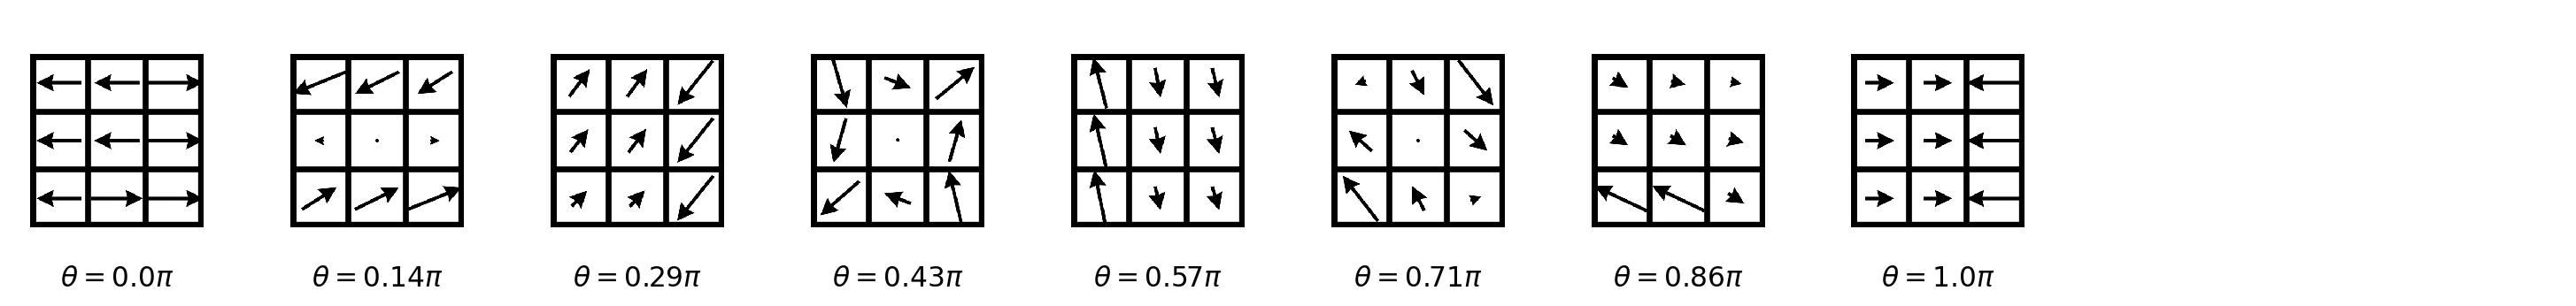

In [3]:
#Show a sample of the data

n_samples = 8

label_func = [fr"$\theta = {np.round(pred/np.pi, 2)}$" + r"$\pi$" for pred in predom_dirs]
file_name = 'opt flow sample.pdf'
save_path = folder_path + file_name
save_path = None
fig = cb.show_data_vis(data, patch_vis, label_func = label_func, angles = predom_dirs, sampling_method = 'angle', max_samples = n_samples, save_path = save_path)
plt.show()


# Bundle Analysis

## Base Projections And Open Cover

### Cover And Nerve Summary
- $n_\text{sets} = 16$, $n_\text{samples} = 150000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 16$
- $\#(\text{1-simplices}) = 16$
- *No recorded simplices in dimensions* $\ge 2$

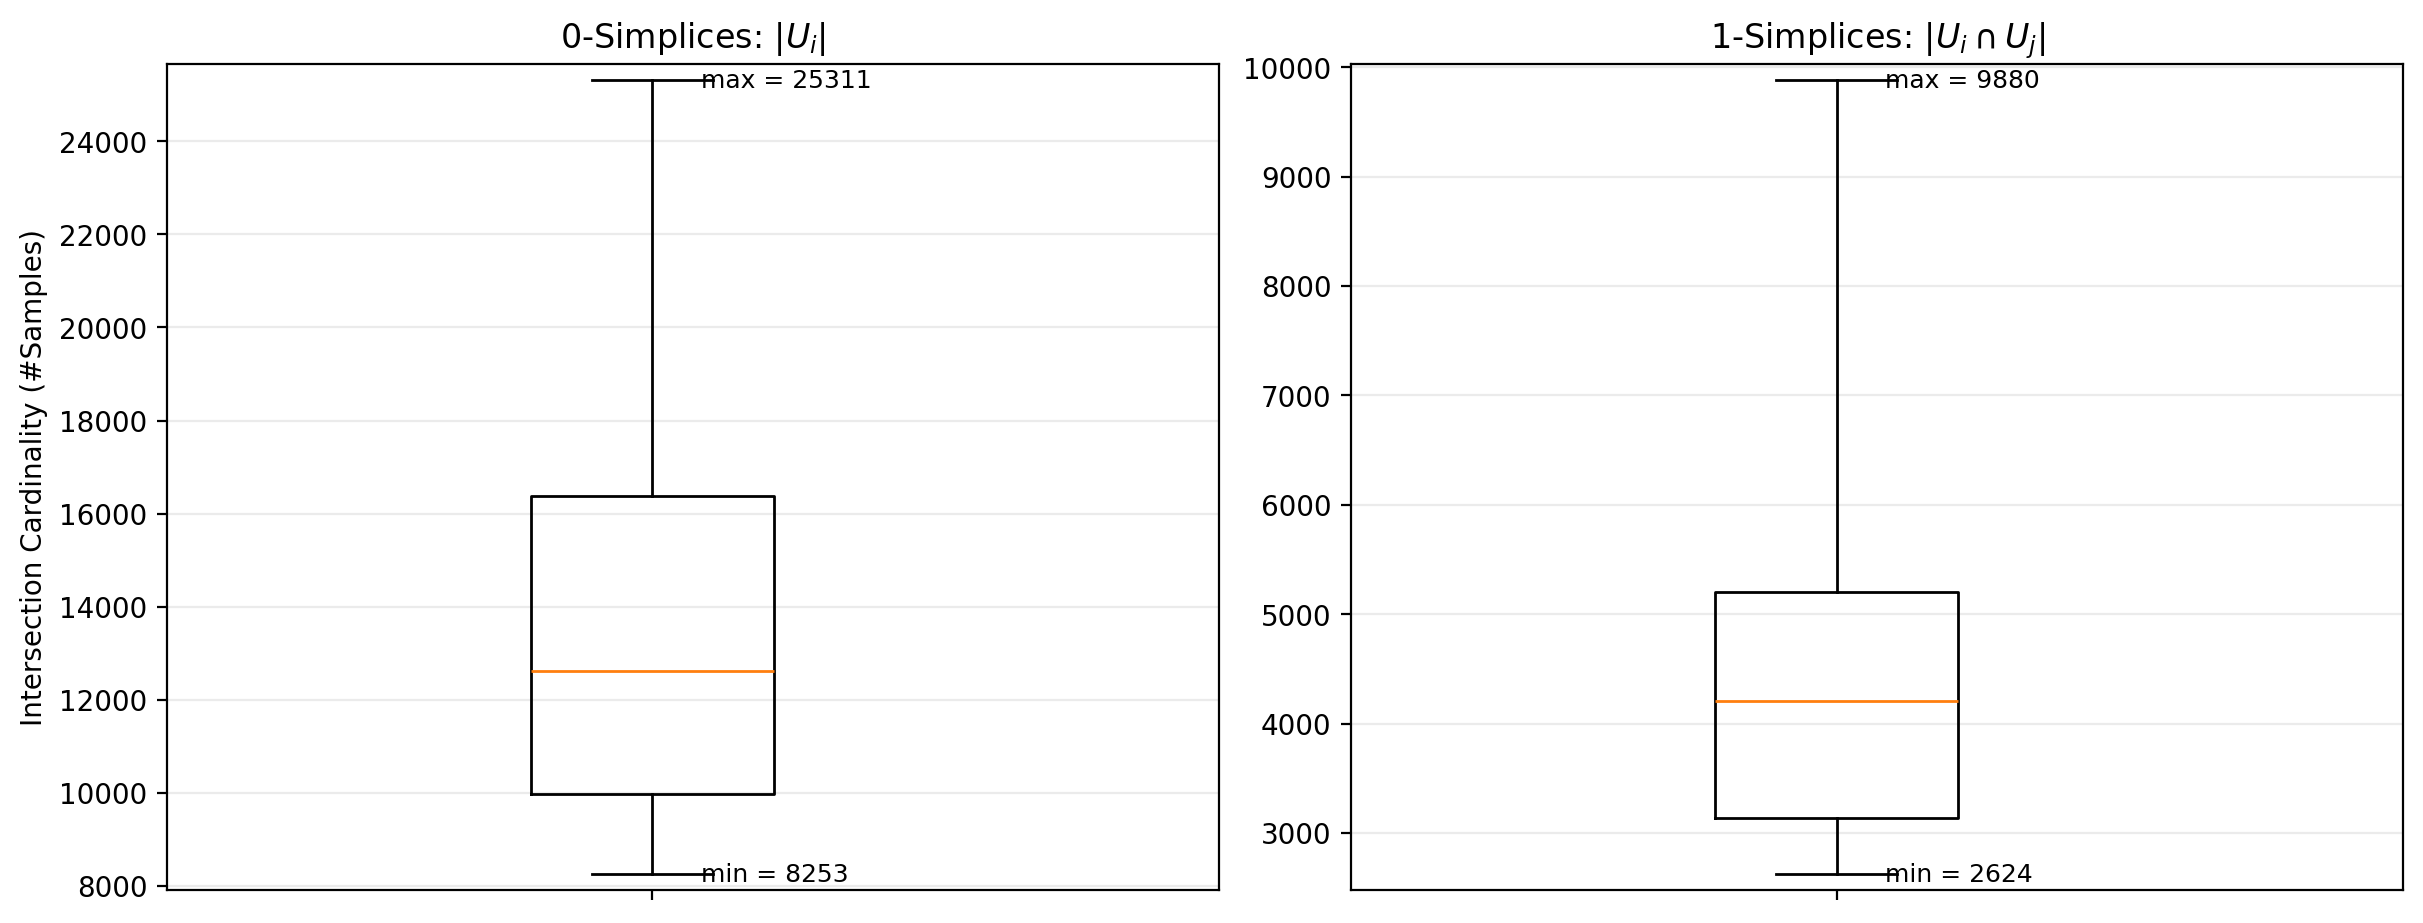

In [4]:
from circle_bundles.metrics import RP1AngleMetric as rp1_metric 

#For visualization, map RP1 angles to points on the unit circle
#base_points = np.array([np.cos(2*predom_dirs), np.sin(2*predom_dirs)]).T
base_points = predom_dirs.reshape(-1,1)

#Construct a cover of the base space
n_landmarks = 16
lmk_angs = np.linspace(0, np.pi,n_landmarks, endpoint= False)
#landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
landmarks = lmk_angs.reshape(-1,1)
overlap = 1.5
radius = overlap* np.pi/(2*n_landmarks)

cover = cb.MetricBallCover(base_points, landmarks, radius, metric = rp1_metric())
cover_data = cover.build()
summ = cover.summarize(plot = True)

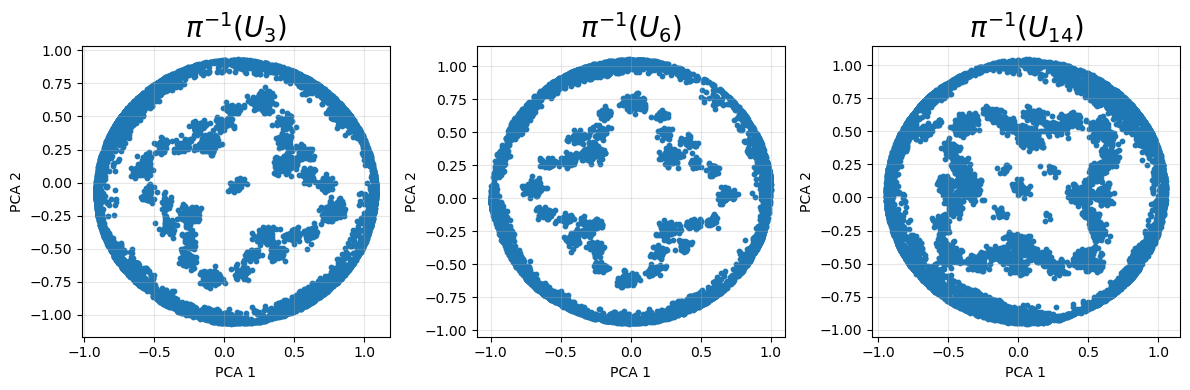

In [5]:
#Show local PCA of the fibers

fiber_ids, dense_idx_list, proj_list = cb.get_local_pca(
    data,
    cover.U,
    p_values=None,
    to_view=[3,6,14],
    n_components=2,
    random_state=None)

file_name = 'Sample_Fiber_Projections_50_60.pdf'
save_path = folder_path + file_name
save_path = None

fig, axes = cb.plot_local_pca(
    fiber_ids,
    proj_list,
    n_cols=3,
    titles='default',
    font_size=20,
    save_path=save_path)

## Fiberwise Clustering

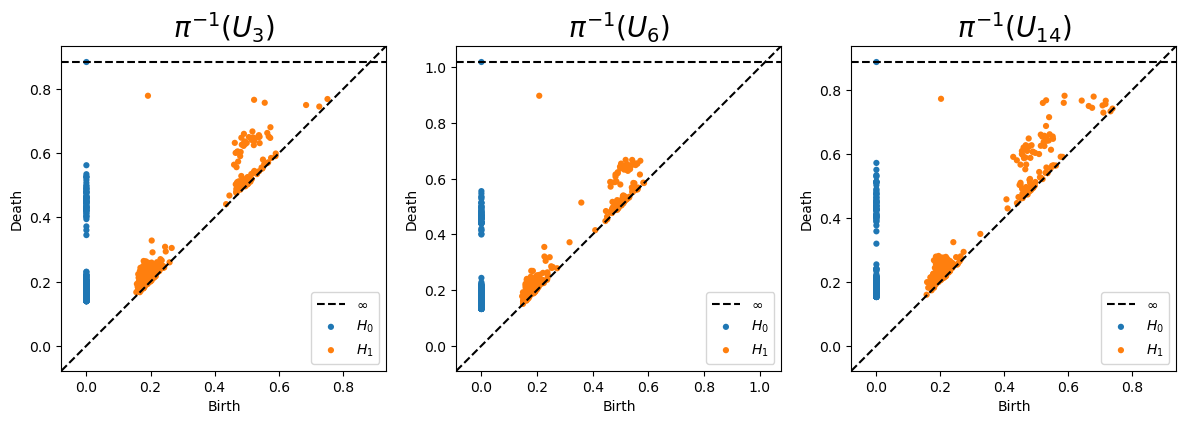

In [6]:
#Compute local 0-D persistence to get an eps value for DBSCAN

to_view = [3,6,14]
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    p_values=None,
    to_view=to_view,
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
    save_path=None,
)

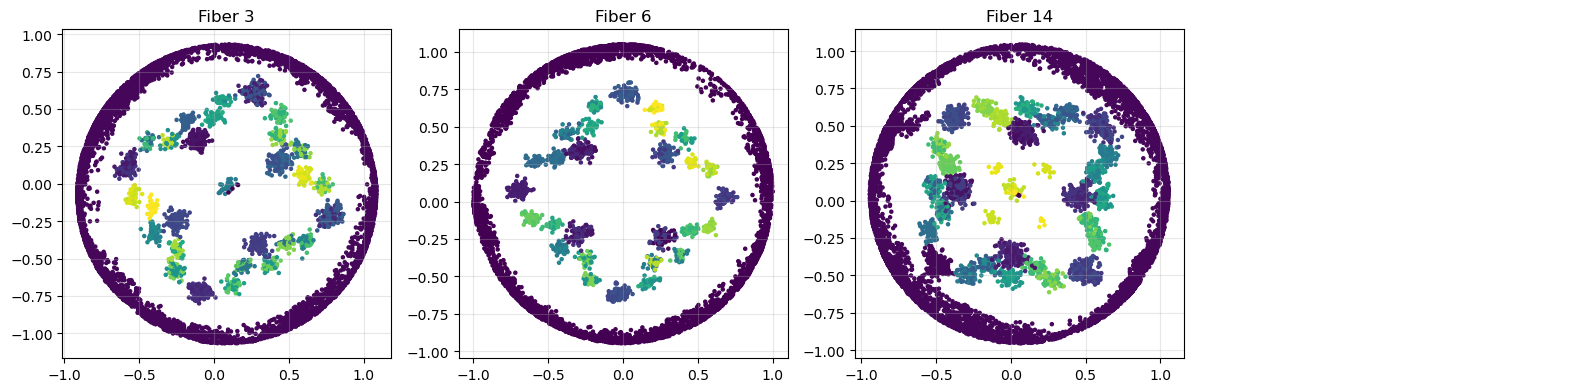

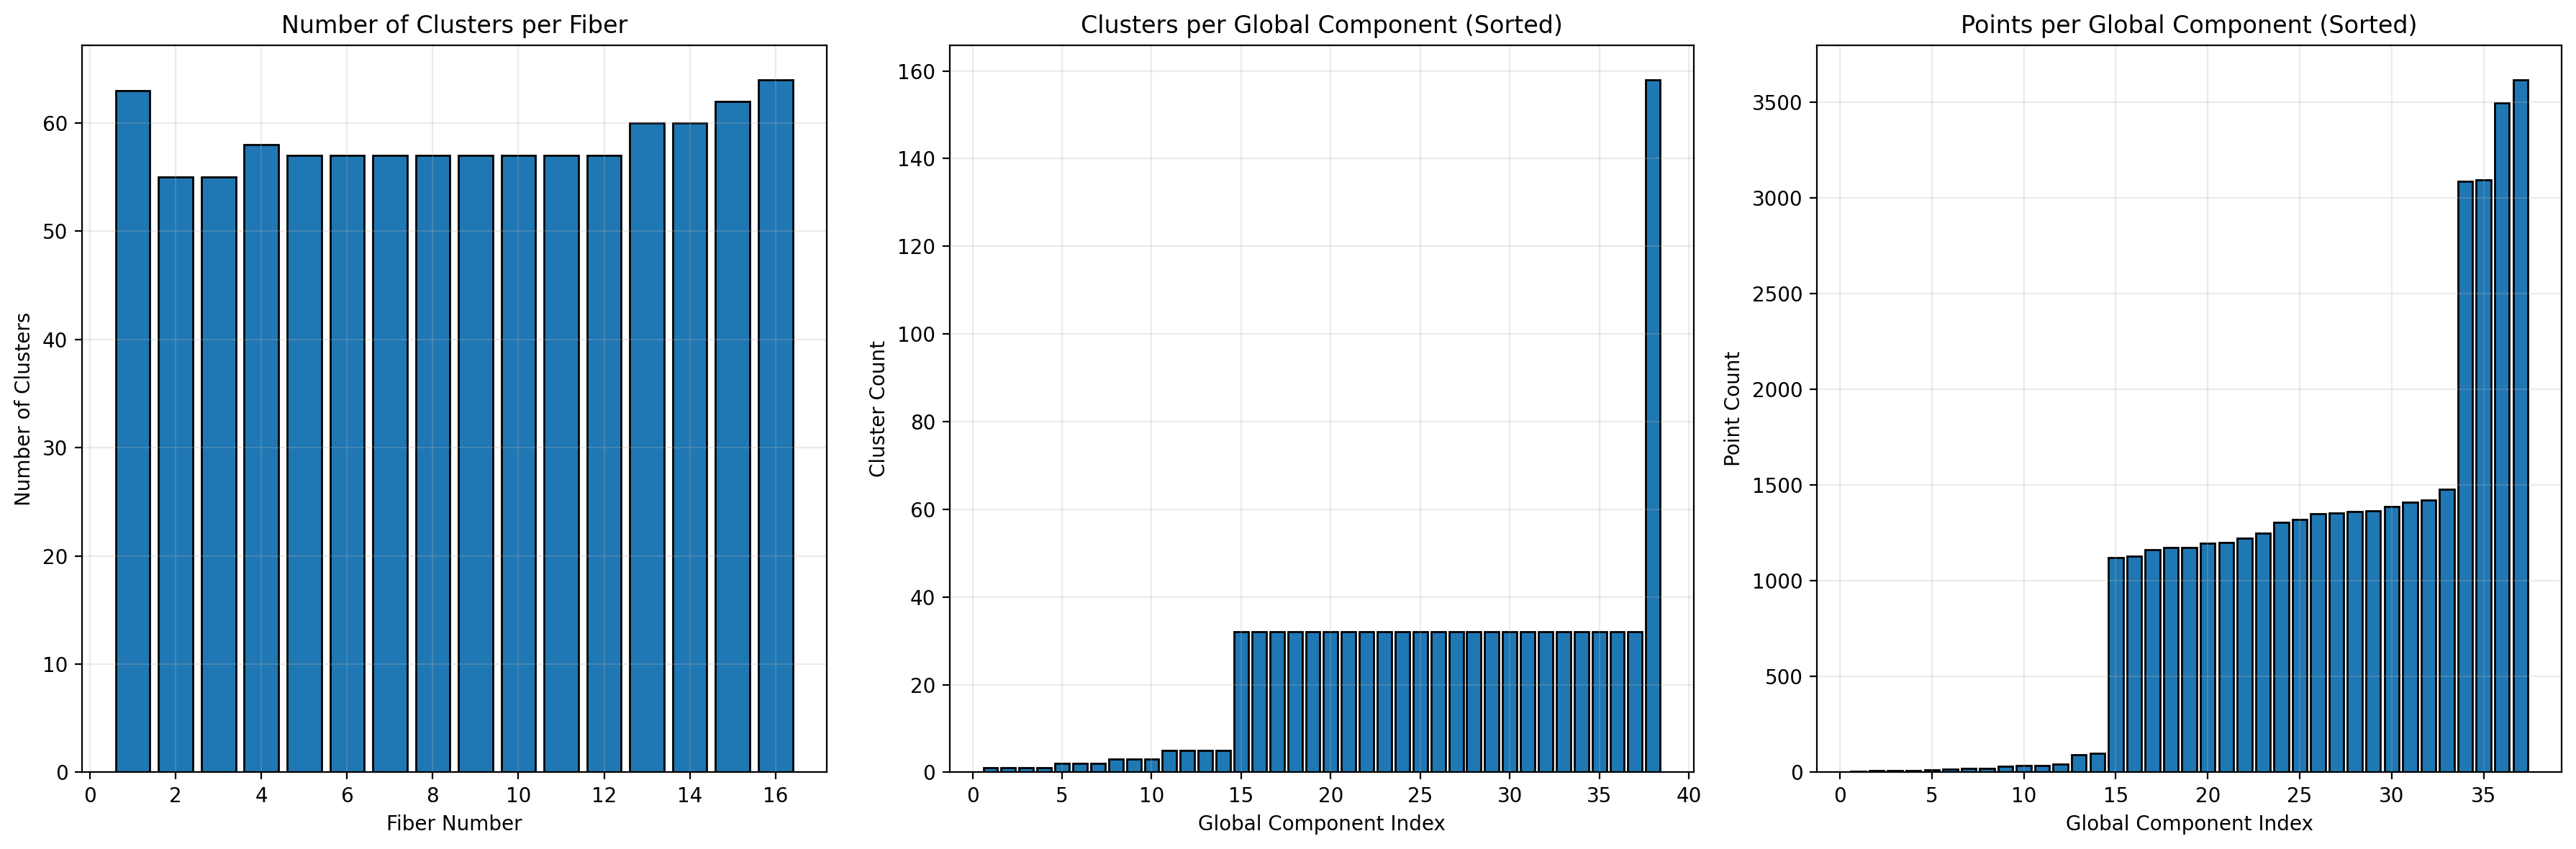

Total number of global clusters: 38
Total number of unclustered points: 18

Global components by size:
[ 0  2  1  8  7 22 10  5 15 11  4  3  9 23  6 14 21 17 16 12 18 20 19 13
 31 26 27 32 28 25 33 36 29 34 24 30 37 35]

Cardinality of each global component:
[111855, 3497, 3617, 1355, 1362, 1411, 1307, 3087, 3093, 1350, 1421, 1366, 1174, 1122, 1249, 1388, 1196, 1199, 1173, 1129, 1163, 1222, 1480, 1321, 10, 32, 93, 43, 34, 18, 9, 99, 35, 22, 14, 7, 21, 8]

Percentage of the data:
[0.75 0.02 0.02 ... 0.   0.   0.  ]


In [7]:
#Run fiberwise clustering
eps_values = 0.3*np.ones(n_landmarks)
min_sample_values = 5*np.ones(n_landmarks)
to_view = [3,6,14]


components, G, graph_dict, cl, summary = cb.fiberwise_clustering(
    data, 
    cover.U, 
    eps_values, 
    min_sample_values
)

file_name = 'Sample_Clustered_Fibers_K(50,60).pdf'
save_path = folder_path + file_name
save_path = None

cb.plot_fiberwise_pca_grid(summary, to_view=to_view, save_path=None)
cb.plot_fiberwise_summary_bars(summary, hide_biggest=True, save_path=None)

n_clusters = len(np.unique(components))-1
print(f'Total number of global clusters: {n_clusters}')
print(f'Total number of unclustered points: {np.sum(components == -1)}')
print('')

point_count = [np.sum(components == j) for j in np.unique(components)[1:]]
print('Global components by size:')
print(np.argsort(point_count)[::-1])
print('')
print('Cardinality of each global component:')
print([int(x) for x in point_count])
print('')
percentages = 100*point_count/np.sum(point_count)
print('Percentage of the data:')
print(np.round(percentages,2))

# Global Clusters

In [8]:
#Get an array whose rows contain the indices of points in the associated global components
C = np.zeros((len(np.unique(components)), len(data)))
for c in range(len(C)):
    if c == (len(C)-1):
        j = -1
    else:
        j = c
    C[c] = components == j


In [ ]:
#Check to see which global clusters have a significant 1D persistent class

fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    C,
    p_values=None,
    to_view=None,
    maxdim=1,
    n_perm=500,
    random_state=None,
)


circular_components = []
others = []
for r in range(len(rips_list)):
    dgm = rips_list[r]['dgms'][1]   #1D persistence diagram for component r
    if len(dgm) > 0:
        b, d = dgm[np.argmax(dgm[:,1] - dgm[:,0])]    #sufficient to run cc
        if 2*b < d:
            circular_components.append(r)
        else:
            others.append(r)
    else:
        others.append(r)

print('components with circular features:')
print(circular_components)
print(f'number of circular components: {len(circular_components)}, number of other components: {len(others)}')


In [ ]:
# Run circular coordinates on each global cluster with a strong circular feature
n_landmarks = 100
prime = 17

datasets = []
angles_list = []
titles = []

for j in circular_components:
    if j > 0:   # Don't run circular coordinates on the main optical flow torus cluster
        indices = (components == j)
        datasets.append(data[indices])
        cc = CircularCoords(data[indices], n_landmarks, prime=prime)
        angles_list.append(cc.get_coordinates())
        titles.append(f'Component {j}')
        
#to_show = [7,20,23, 4, 5, 6]
file_name = 'Sample_ccs_50_60.pdf'
save_path = folder_path + file_name


fig, axes = cb.circle_vis_grid(
    datasets,
    angles_list,
    patch_vis,
    titles=titles,
    per_circle=8,
    circle_radius=1.0,
    extent_factor=1.2,
    circle_zoom=0.13,
    circle_linewidth=1.0,
    circle_color="black",
    n_cols=3,
    title_fontsize=16,
    figsize_per_panel=5,
    fig_dpi=150,
    save_path=None,
)
plt.show()

In [ ]:
#View a visualization of a circular component of G


file_name = 'G_component_vis.pdf'
save_path = folder_path + file_name
save_path = None

fig, ax, comp = cb.plot_component_patch_diagram(
    G, data, cl, patch_vis,
    component_index=1,
    image_zoom=0.35,
    row_spacing=4,
    col_spacing=3.5,
    line_color="lightgray",
    line_width=5,
    save_path=None,
)
plt.show()


In [ ]:
#View samples in each 'non-circular' global cluster 
max_samples = 5
n_clusters = len(np.unique(components))-1
for j in others:
    if j == n_clusters:
        inds = components == -1
    else:
        inds = components == j
        
    print(f'Sample patches from global cluster {j} ({int(np.sum(C, axis = 1)[j])} total):')
    fig = cb.show_data_vis(data[inds], patch_vis, angles = predom_dirs[inds], sampling_method = 'angle', max_samples = max_samples)
    plt.show()


In [ ]:
#Get a single representative from each outlier cluster
patch_reps = np.zeros((len(others)-1, 18))
for t, j in enumerate(others):
    if j != n_clusters:
        if j == 25:
            patch_reps[t] = data[components == j][27]
        else:
            patch_reps[t] = data[components == j][0]

file_name = 'Outlier_Patches.pdf'
save_path = folder_path + file_name
save_path = None

fig = cb.show_data_vis(patch_reps, patch_vis, n_cols = 7, save_path = save_path)
plt.show()



## Cluster Persistence

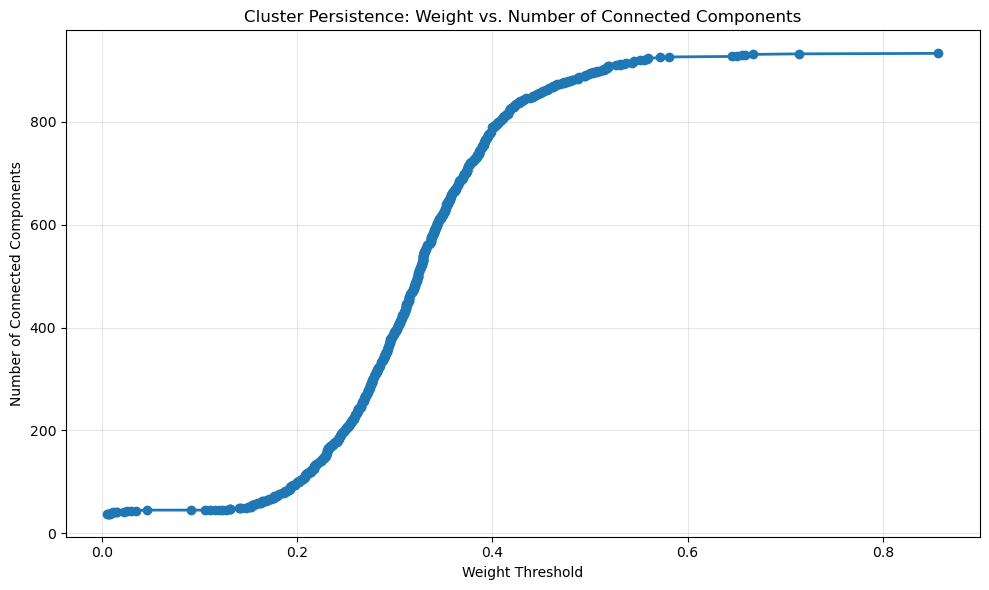

In [9]:
#Compute cluster persistence

file_name = 'Cluster_Persistence_K(50,60).pdf'
save_path = folder_path + file_name
save_path = None
G = cb.get_weights(G, method='rel_card2')
comp_pers = cb.get_cluster_persistence(G, save_path = save_path)

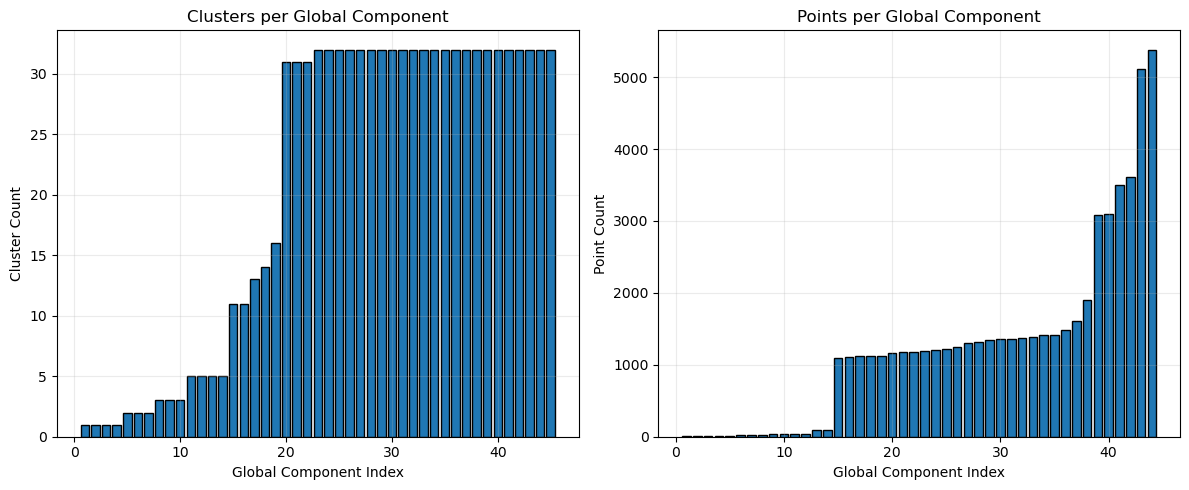

threshold: 0.07, global clusters: 45
number of deleted edges: 14


In [10]:
#Replace G with G^{(0.07)}
thresh = 0.07

folder_path = '/Users/bradturow/Desktop/Diagrams/Clean_Diagrams/'
file_name = 'G07_Clustering_Summary.pdf'
save_path = folder_path + file_name
save_path = None
filtered_components, filtered_G, filtered_graph_dict, filtered_cl, comp_inds = cb.get_filtered_cluster_graph(
    data,
    G,
    cl,
    thresh = thresh,
    rule = "to_smaller_cluster",
    show_results = True,
    hide_biggest = True,
    save_path = save_path,
)


print(f'threshold: {thresh}, global clusters: {len(comp_inds)}')

print(f'number of deleted edges: {len(G.edges) - len(filtered_G.edges)}')


## The Filtered Cluster Graph 

In [ ]:
#View a visualization of G0 before and after filtering G
#(the largest connected component)
import networkx as nx


#Get the subgraph of G containing just the largest connected component
G_comps = list(nx.connected_components(G))
G0 = G.subgraph(G_comps[0]).copy()

#Get the filtered version of G0
thresh = 0.07
filtered_G0 = cb.get_filtered_cluster_graph(data, G0, cl, thresh = thresh, show_results = False)[1]


#Get coordinates for nodes in visualization
vertex_coords = cb.get_G_vertex_coords(G0)

#Convert to a simplex tree and get color assignments
G0_st, filtered_G0_st, vertex_dict, edge_dict, node_to_index = cb.create_st_dicts(G0, filtered_G0)


cmap = {
    4: '#DCE6F2',  # very light blue
    3: '#B0C4E8',  # soft periwinkle
    2: '#8090D1',  # medium lavender-blue
    0: 'black',  # deep violet-blue
    1: '#3F3FBF',  # rich indigo
    5: '#2A2A9F',  # dark blue accent
    6: '#8866CC',  # soft purple accent
    7: '#5C2ABF',  # vibrant purple
   -1: 'red'   # gray for special/missing
}

file_name = 'Largest_Cluster_Graph_Vis2.pdf'
save_path = folder_path + file_name
save_path = None

fig, axes = cb.nerve_vis(
    G0_st,
    vertex_coords,
    cochains={0:vertex_dict, 1:edge_dict},
    base_colors={0:'black', 1:'black'},
    cochain_cmaps={0:cmap, 1:cmap},
    opacity=0,
    node_size=15,
    line_width=1,
    node_labels=None,
    vis_func=None,
    data=None,
    image_zoom=0.1,
    save_path=save_path,
    title=r'Visualization Of $G_{0}$'
)

plt.show()


In [11]:
#Check to see which global clusters have a significant 1D persistent class

fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    comp_inds,
    p_values=None,
    to_view=None,
    maxdim=1,
    n_perm=500,
    random_state=None,
)


circular_components = []
others = []
for r in range(len(rips_list)):
    if rips_list[r] is not None:

        dgm = rips_list[r]['dgms'][1]   #1D persistence diagram for component r
        if len(dgm) > 0:
            b, d = dgm[np.argmax(dgm[:,1] - dgm[:,0])]    
            if 2*b < d:    #sufficient to run cc
                circular_components.append(r)
            else:
                others.append(r)
        else:
            others.append(r)
    else:
        others.append(r)
print('components with circular features:')
print(circular_components)
print(f'number of circular components: {len(circular_components)}, number of other components: {len(others)}')


/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:247: UserWarning: The input matrix is square, but the distance_matrix flag is off.  Did you mean to indicate that this was a distance matrix?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


components with circular features:
[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
number of circular components: 27, number of other components: 18


/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(
/Users/bradturow/anaconda3/envs/tda_env/lib/python3.10/site-packages/ripser/ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


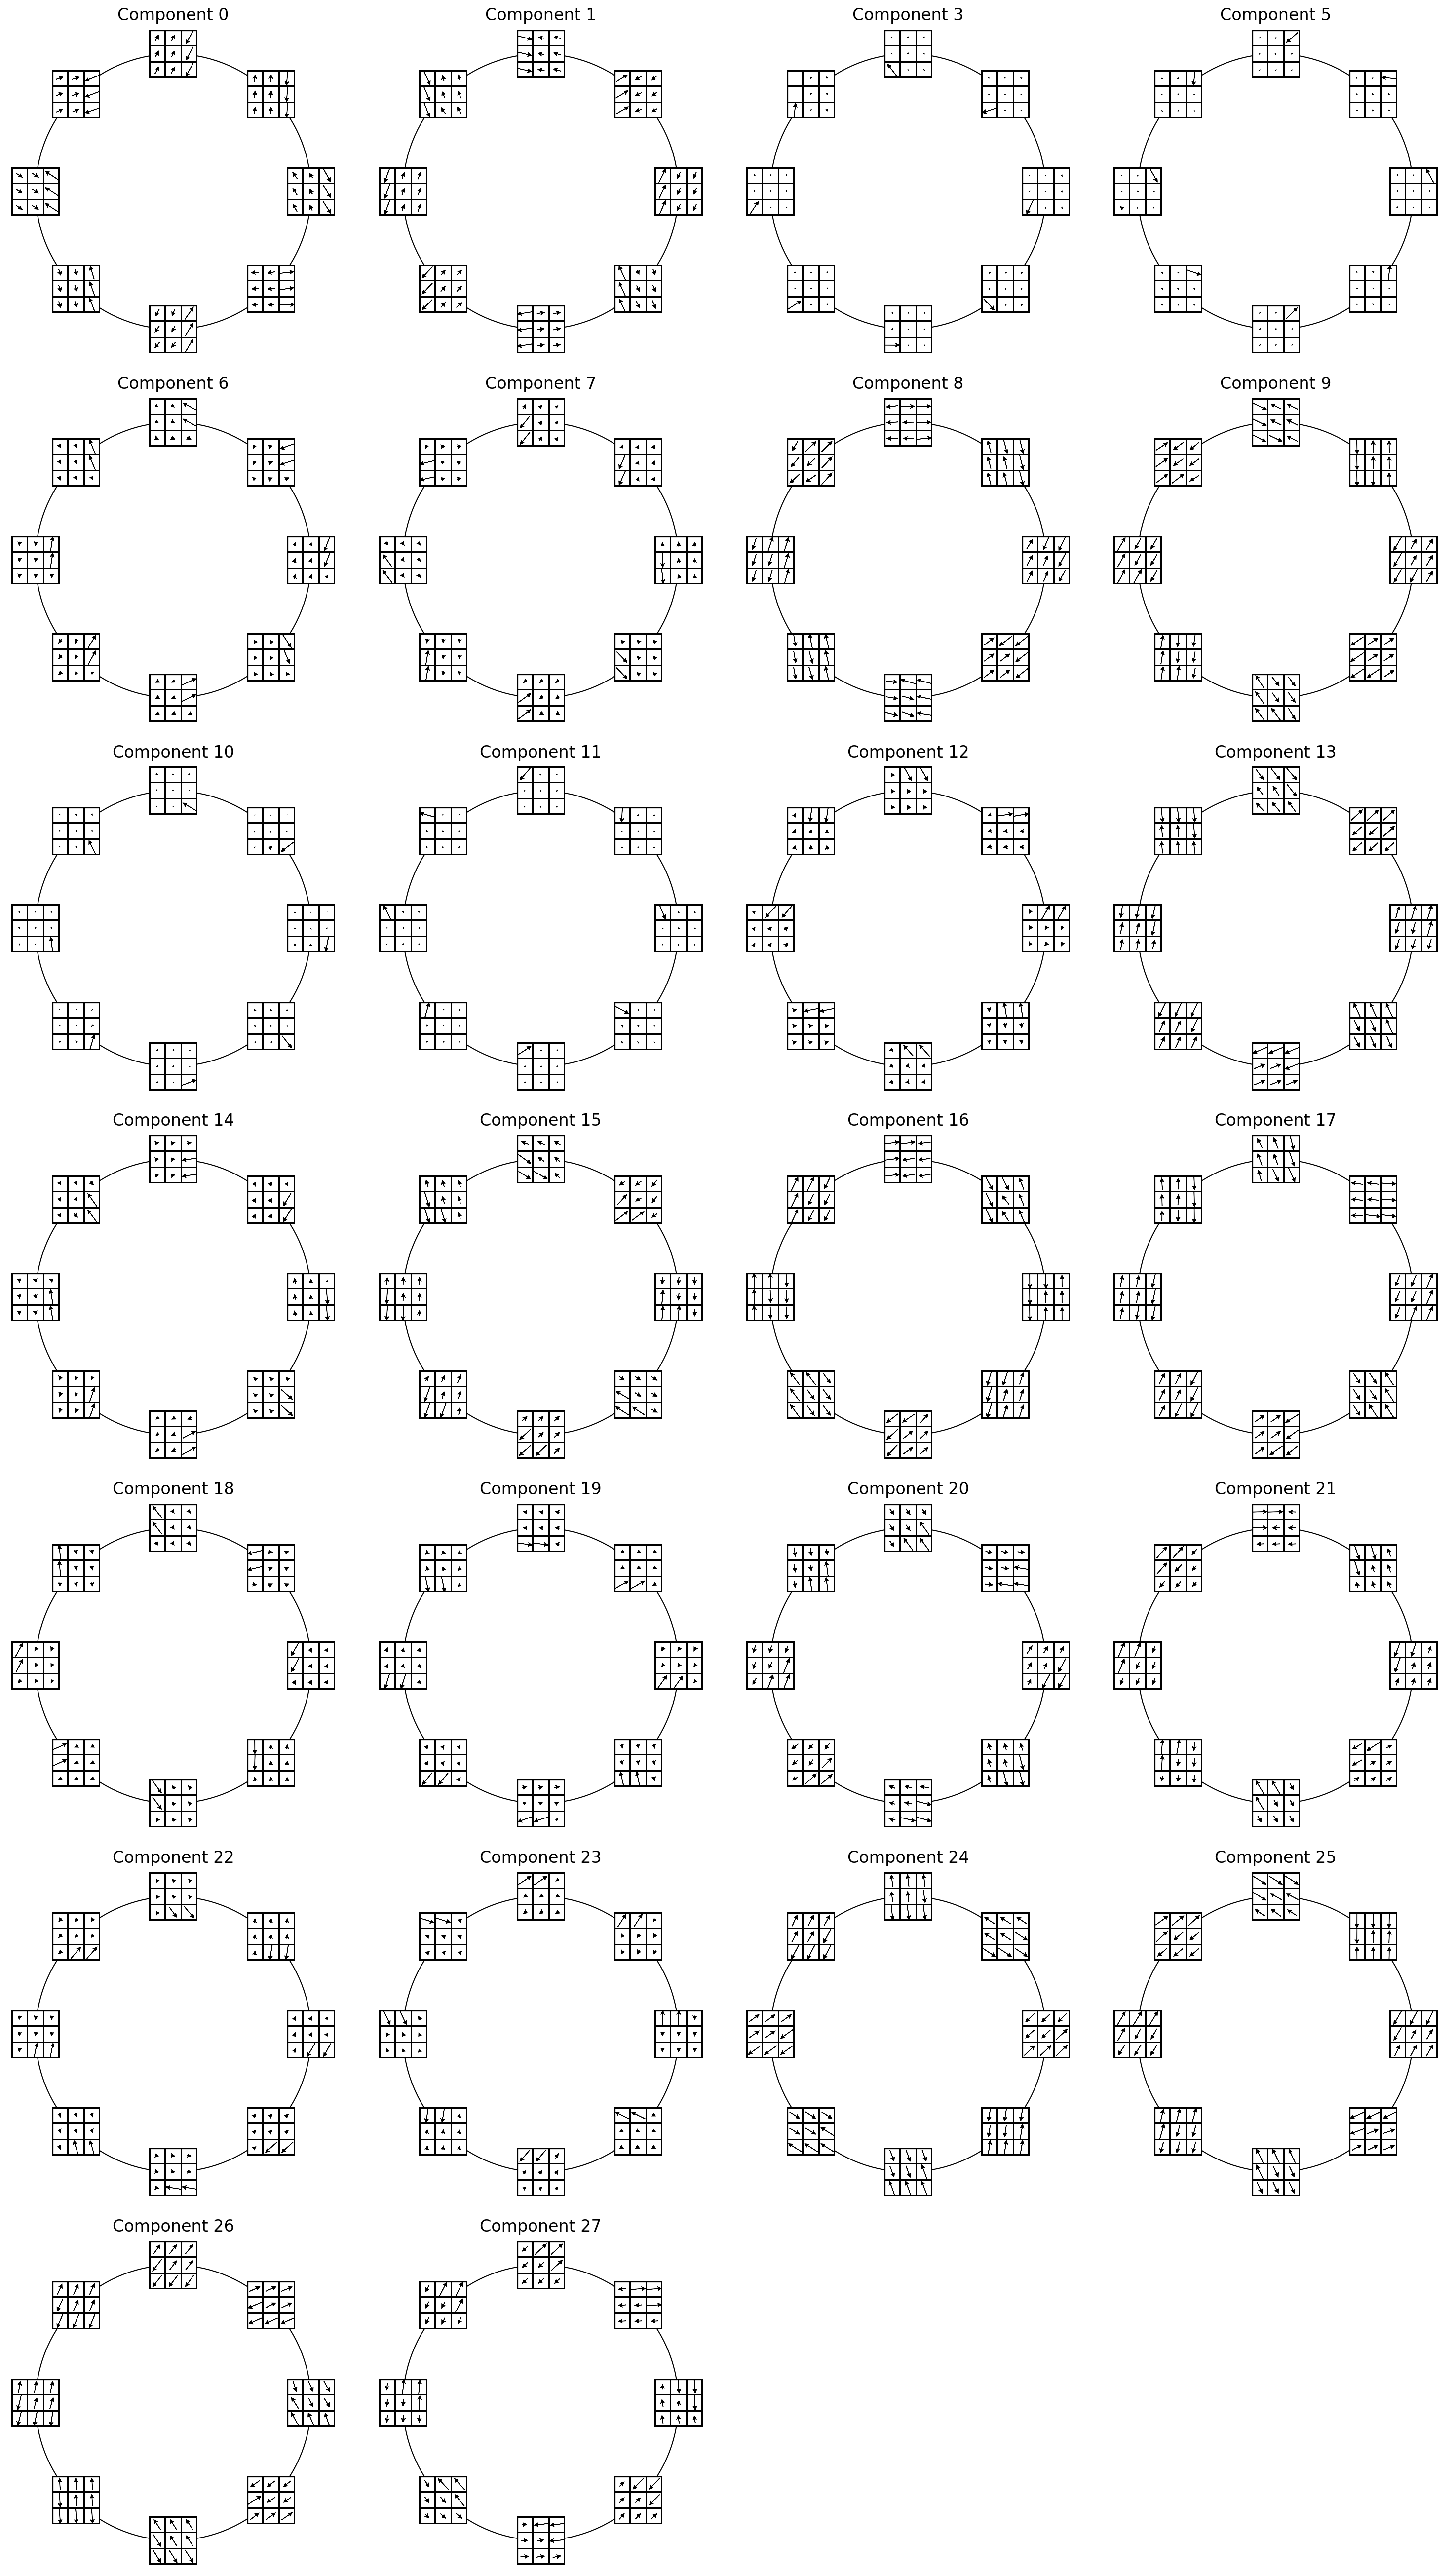

In [16]:
# Run circular coordinates on each global cluster with a strong circular feature

#Ignore the largest component corresponding to the optical flow torus
biggest = np.argmax([np.sum(row) for row in comp_inds])

n_landmarks = 100
prime = 17

file_name = 'Sample_ccs_50_60_filtered.pdf'
save_path = folder_path + file_name

datasets = []
angles_list = []
titles = []

for j in circular_components:
    if j != biggest:   
        indices = comp_inds[j].astype(bool)
        datasets.append(data[indices])
        cc = CircularCoords(data[indices], n_landmarks, prime=prime)
        angles_list.append(cc.get_coordinates())
        titles.append(f"Component {j}")

#Show a sample of coordinatized patches from each circular component
#to_show = [7,20,23, 4, 5, 6]
file_name = 'Sample_ccs_50_60.pdf'
save_path = folder_path + file_name

fig, axes = cb.circle_vis_grid(
    datasets,
    angles_list,
    patch_vis,
    titles=titles,
    per_circle=8,
    circle_radius=1.0,
    extent_factor=1.2,
    circle_zoom=0.13,
    circle_linewidth=1.0,
    circle_color="black",
    n_cols=4,
    title_fontsize=16,
    figsize_per_panel=5,
    fig_dpi=150,
    save_path=None,
)
plt.show()

In [ ]:
#Get a sample patch from each circle
samples = np.vstack([data[0] for data in datasets])
save_path = None
fig = cb.show_data_vis(samples, patch_vis, save_path = save_path)
plt.show()


## Composite Circles

Sample patches from global cluster 2 (1897 total)


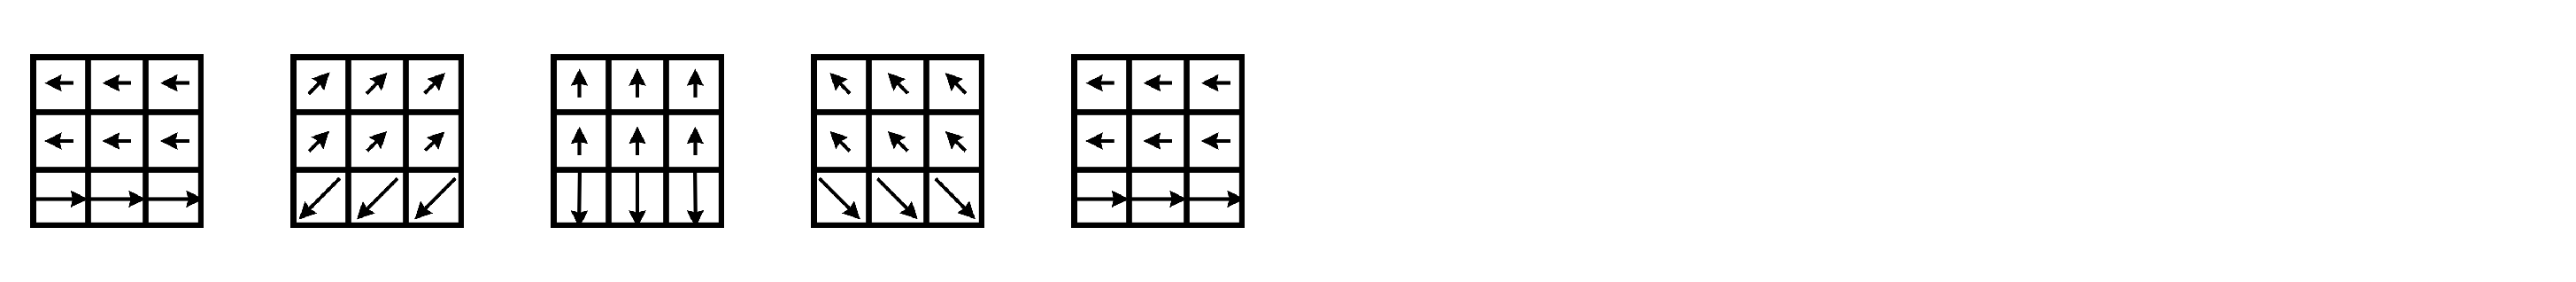

Sample patches from global cluster 28 (10 total)


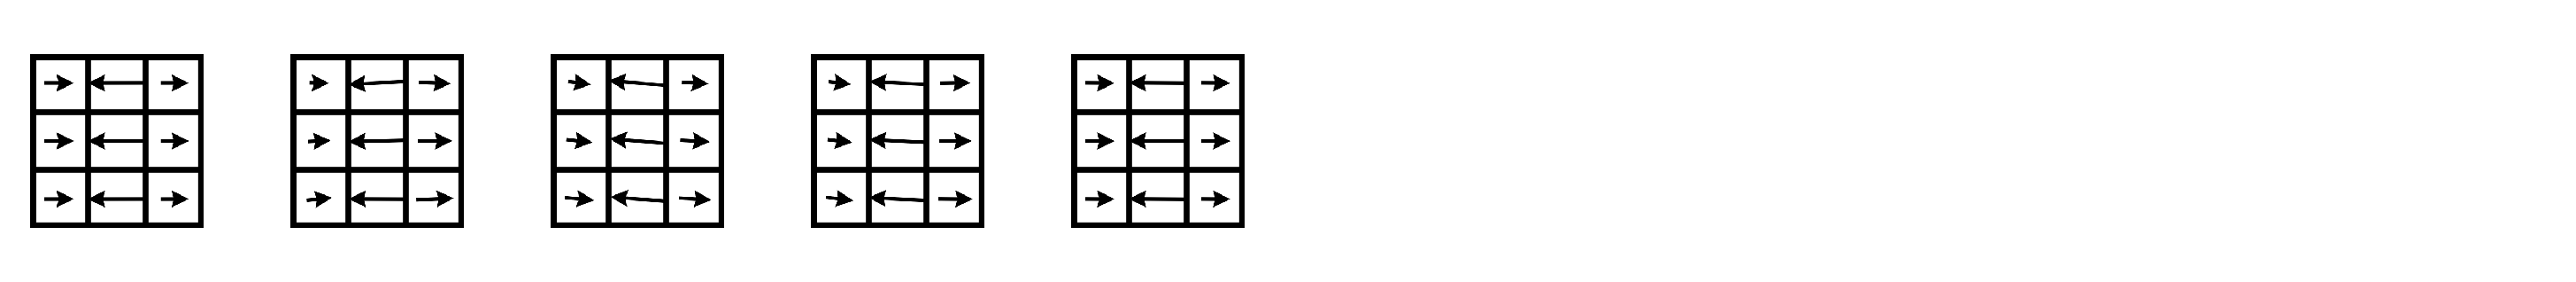

Sample patches from global cluster 29 (32 total)


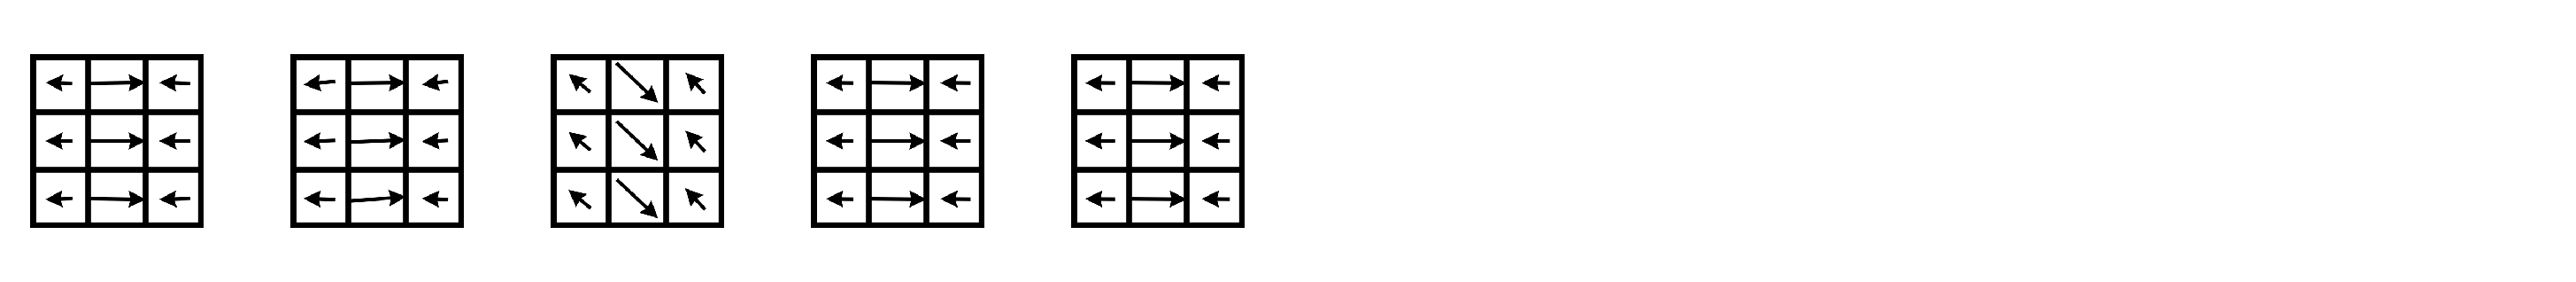

Sample patches from global cluster 30 (93 total)


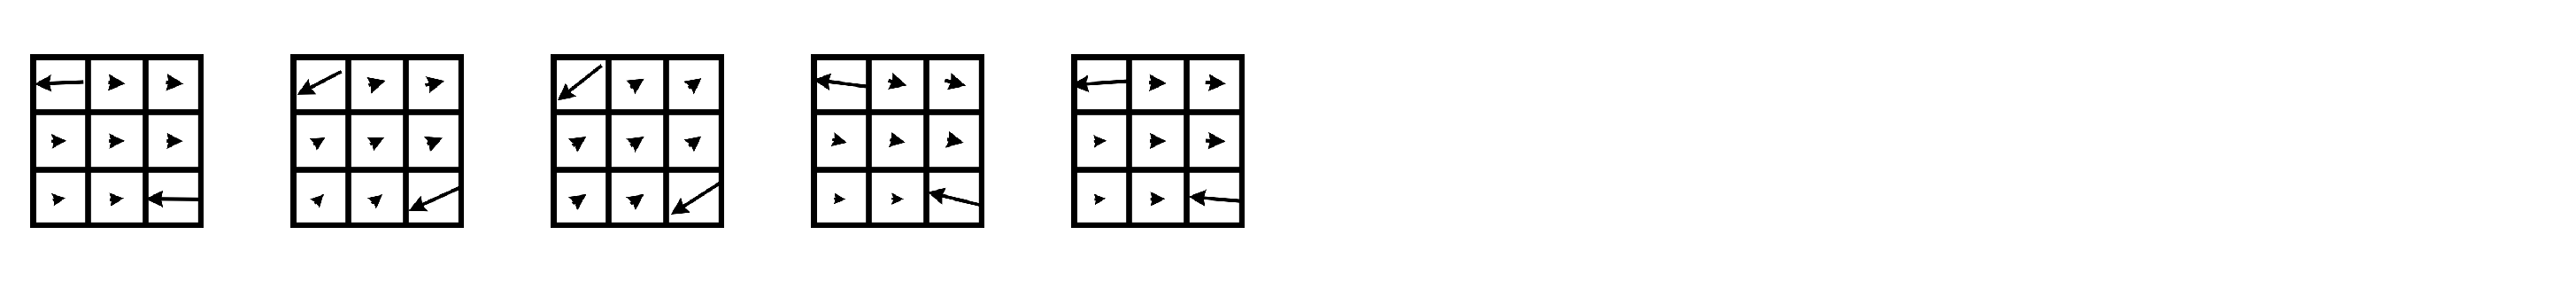

Sample patches from global cluster 31 (43 total)


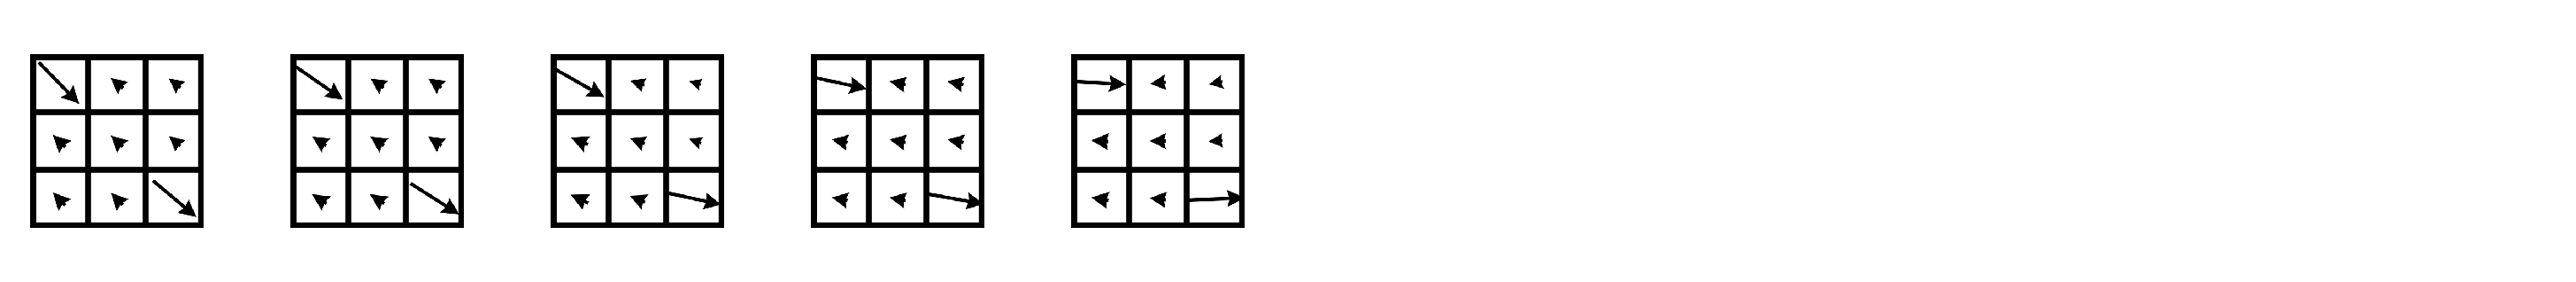

Sample patches from global cluster 32 (34 total)


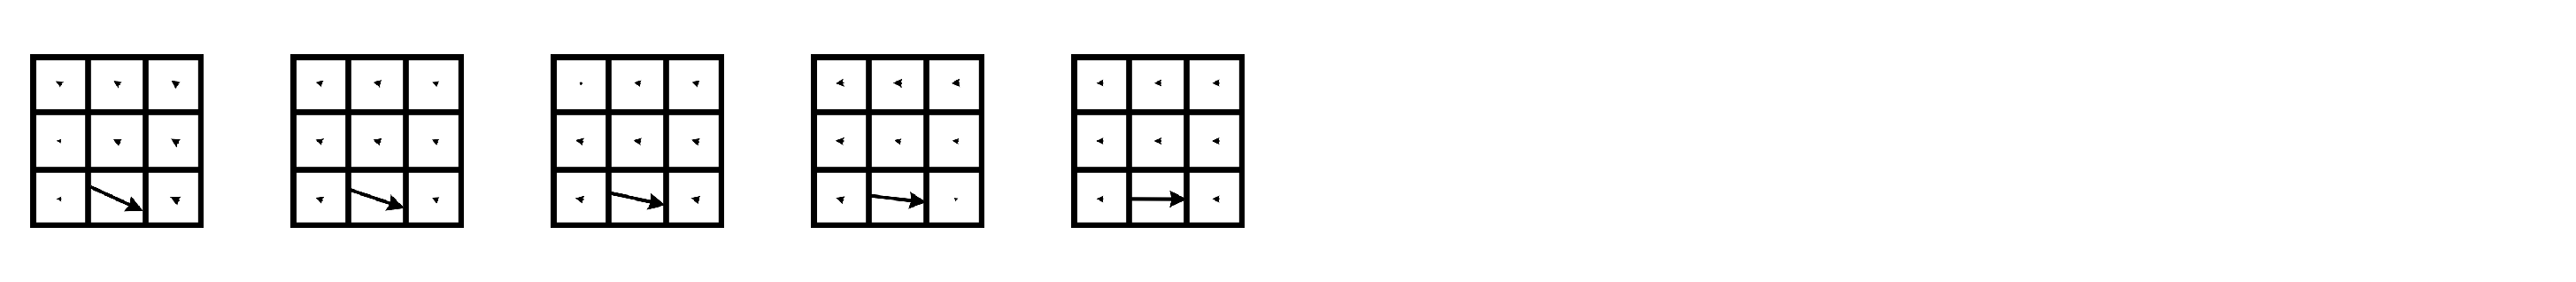

Sample patches from global cluster 33 (18 total)


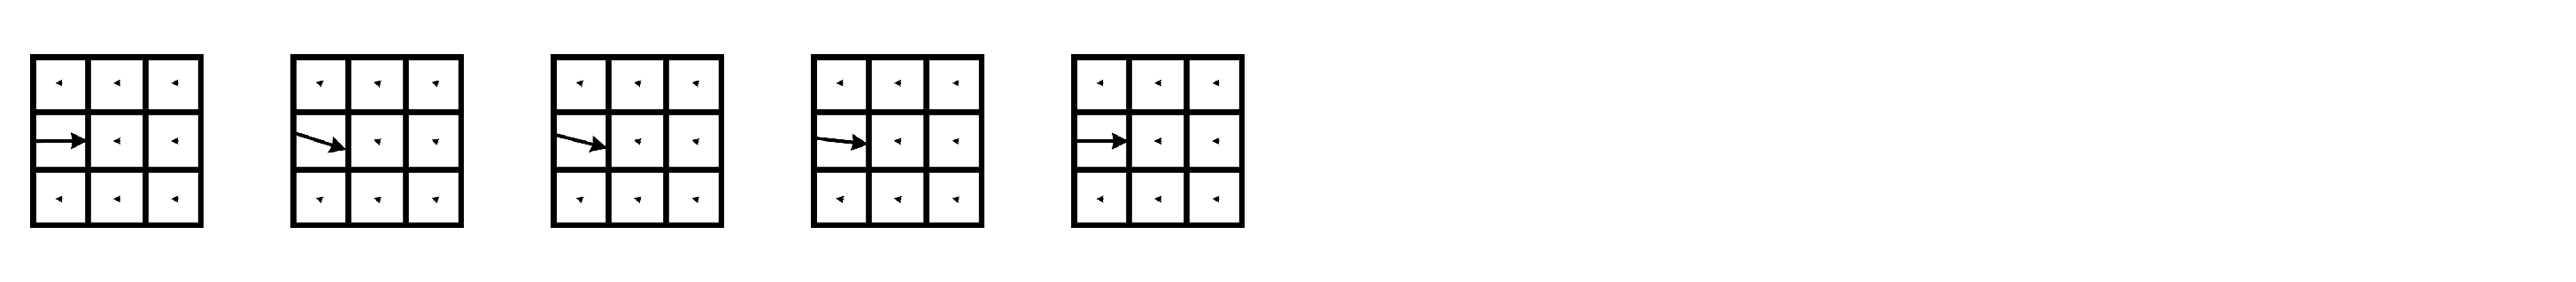

Sample patches from global cluster 34 (9 total)


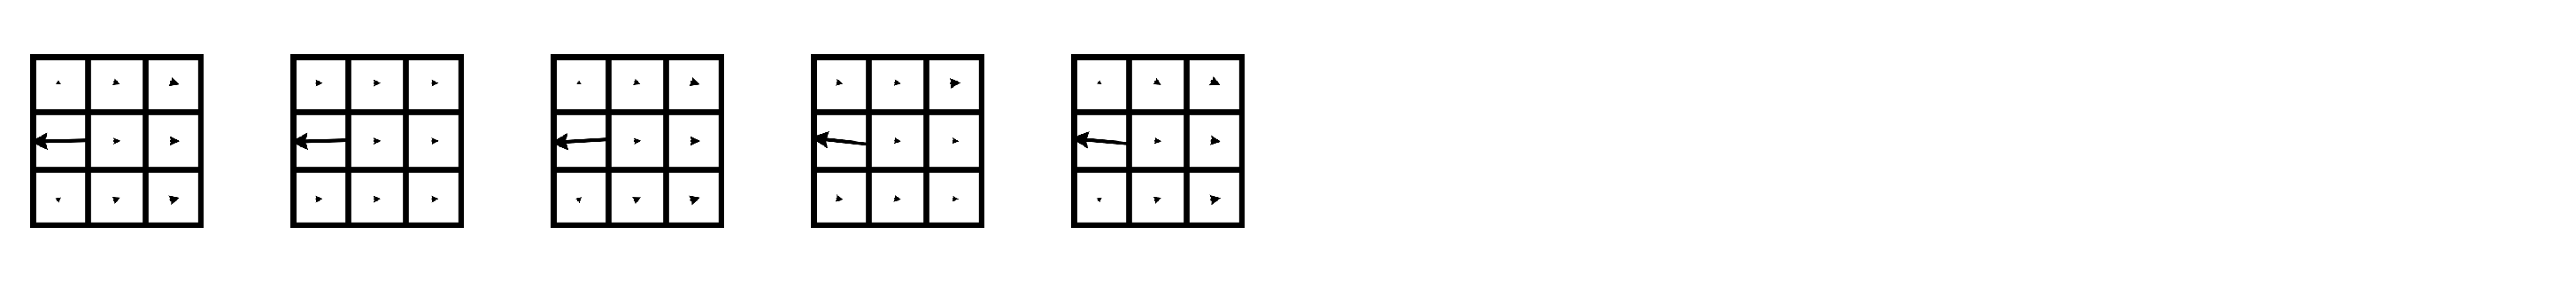

Sample patches from global cluster 35 (99 total)


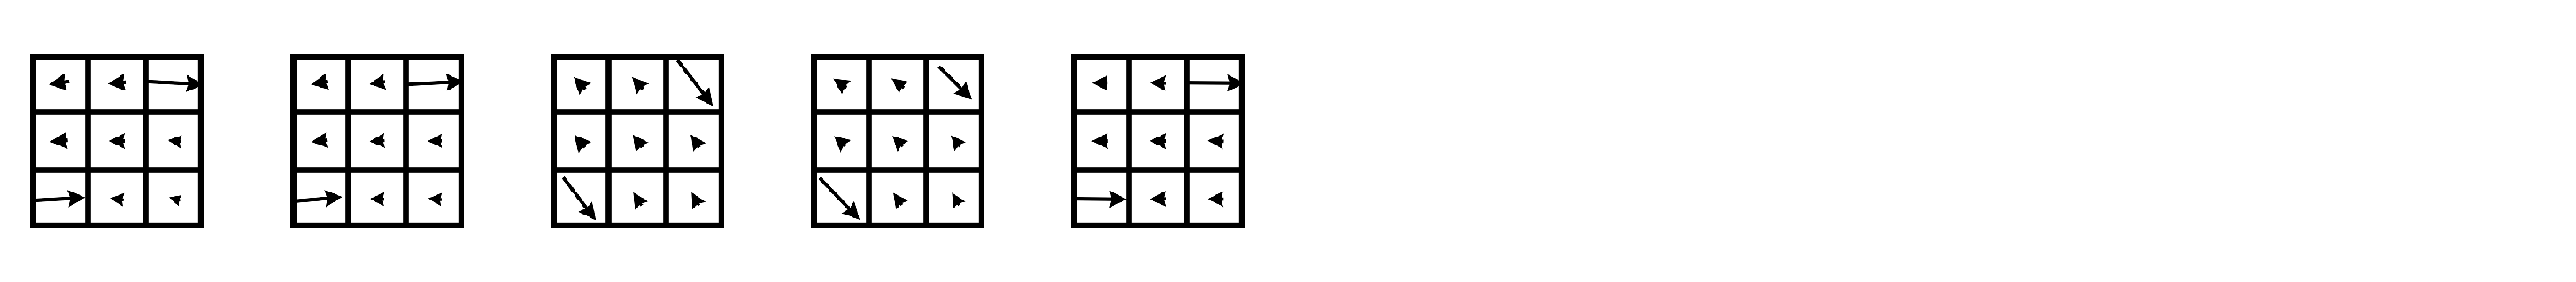

Sample patches from global cluster 36 (35 total)


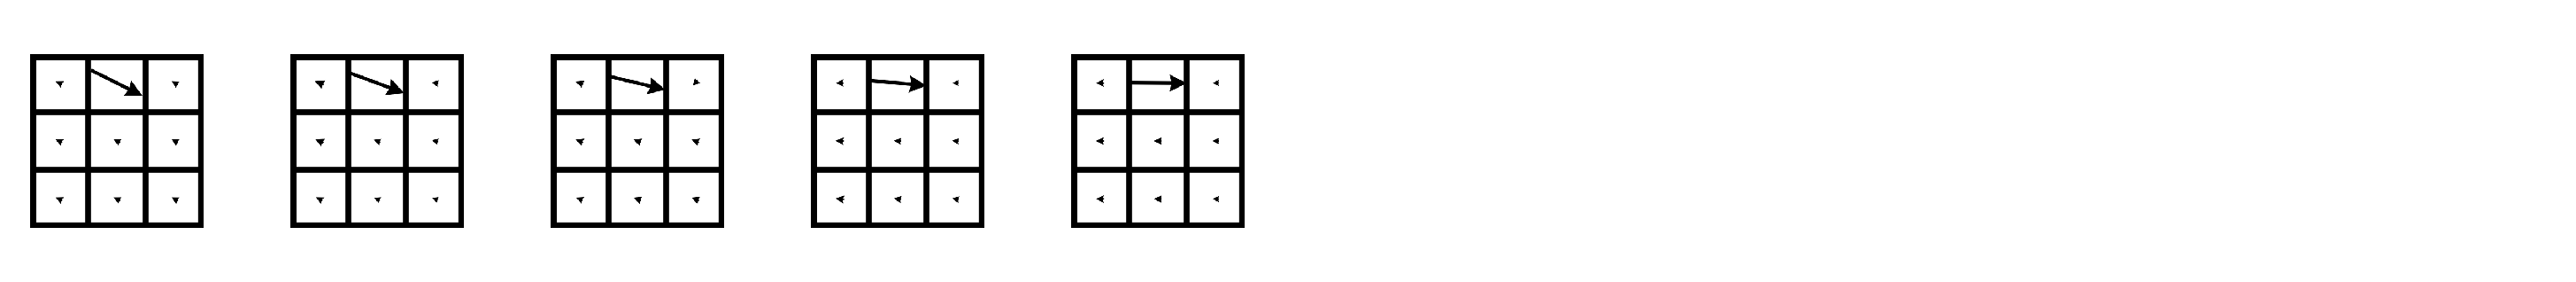

Sample patches from global cluster 37 (22 total)


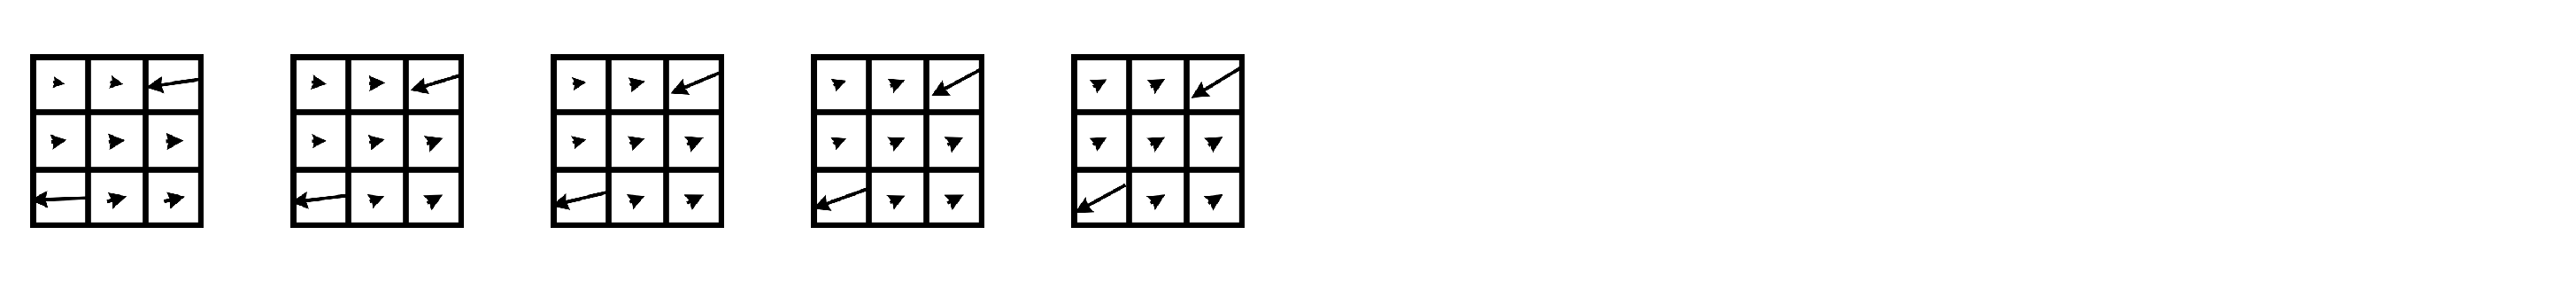

Sample patches from global cluster 38 (1088 total)


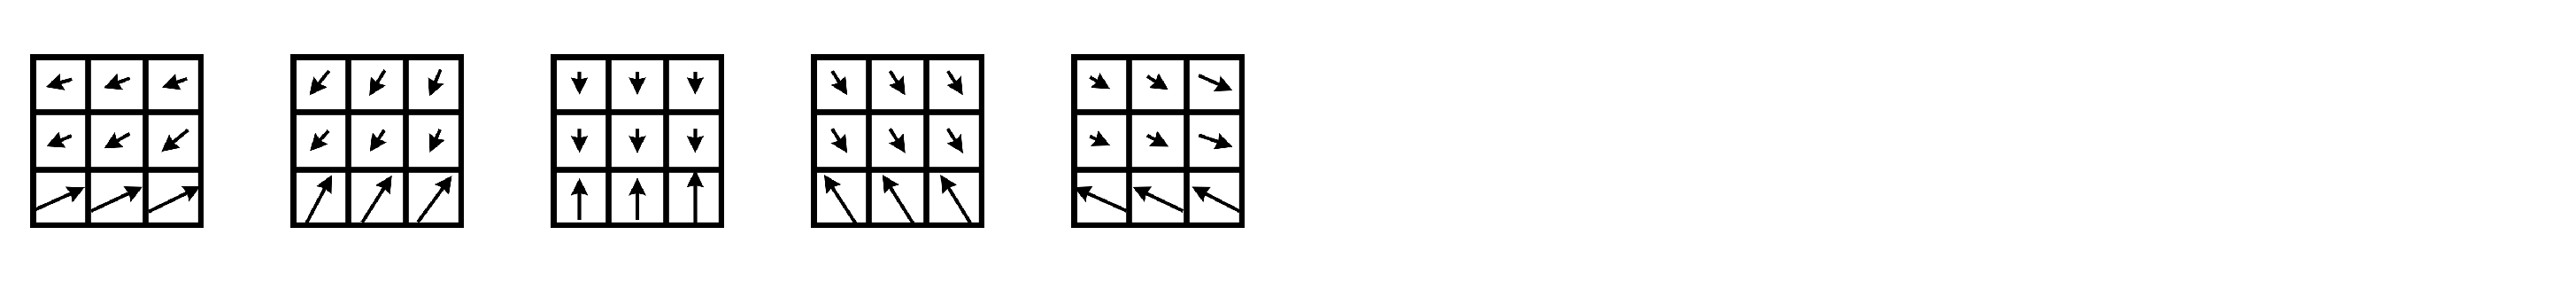

Sample patches from global cluster 39 (1612 total)


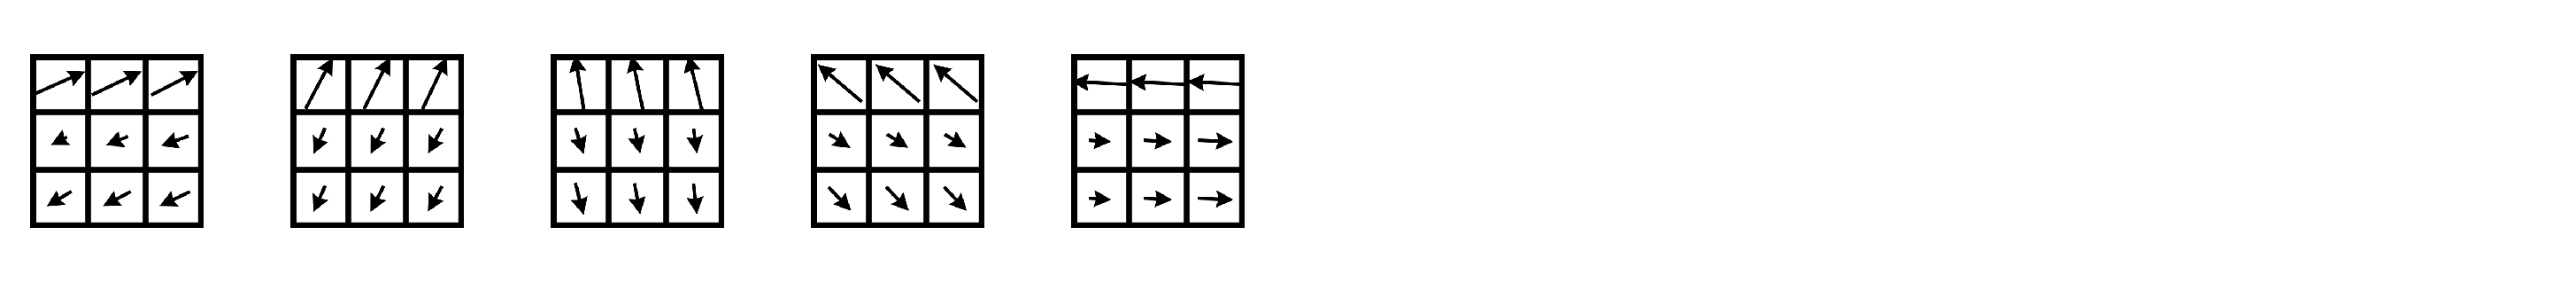

Sample patches from global cluster 40 (1120 total)


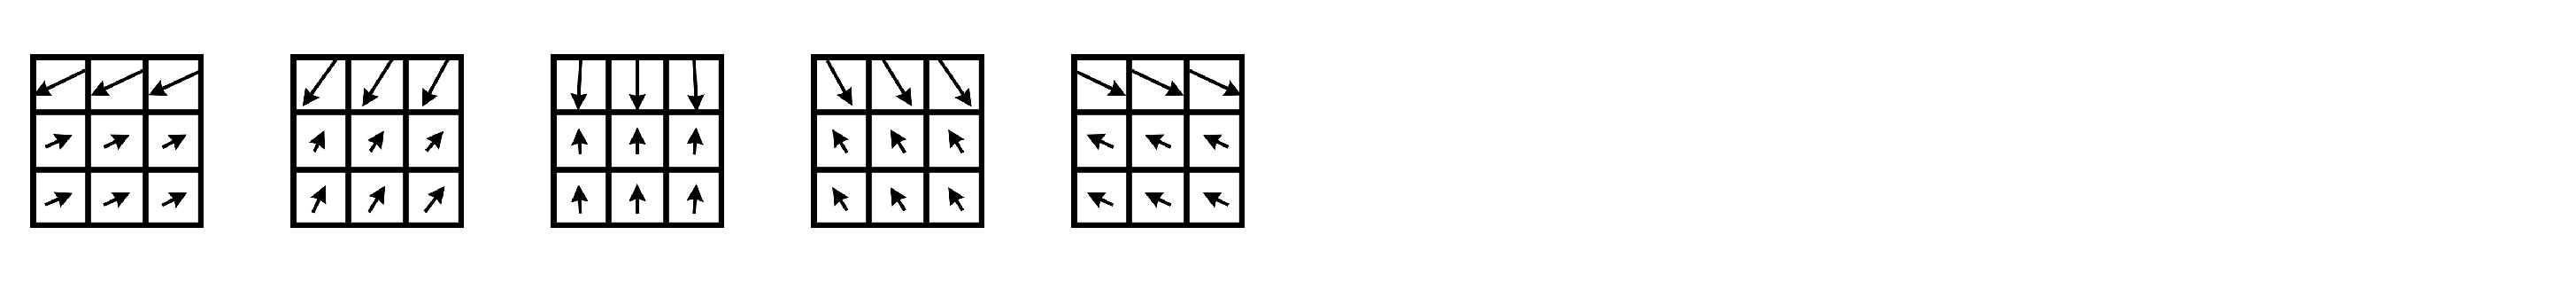

Sample patches from global cluster 41 (14 total)


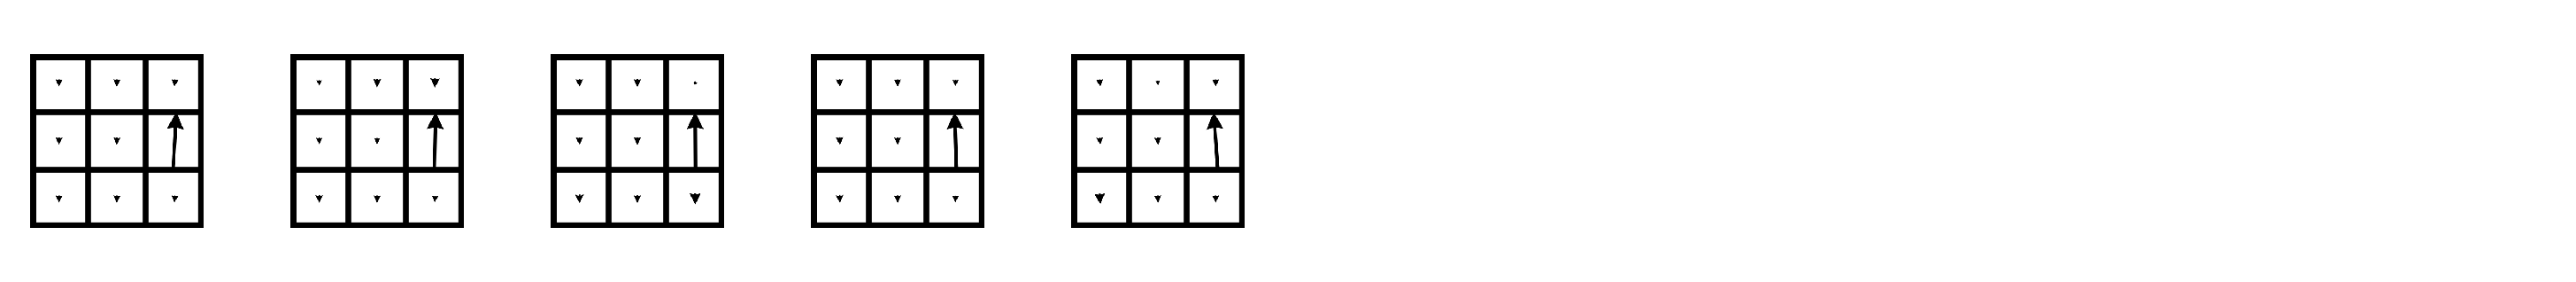

Sample patches from global cluster 42 (7 total)


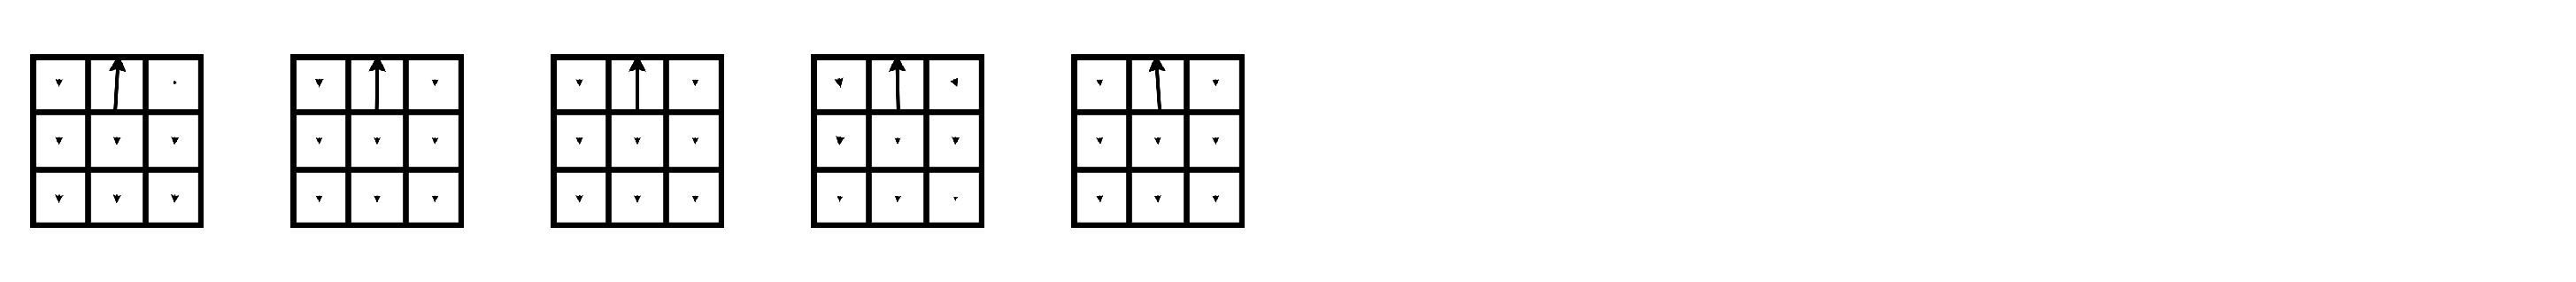

Sample patches from global cluster 43 (21 total)


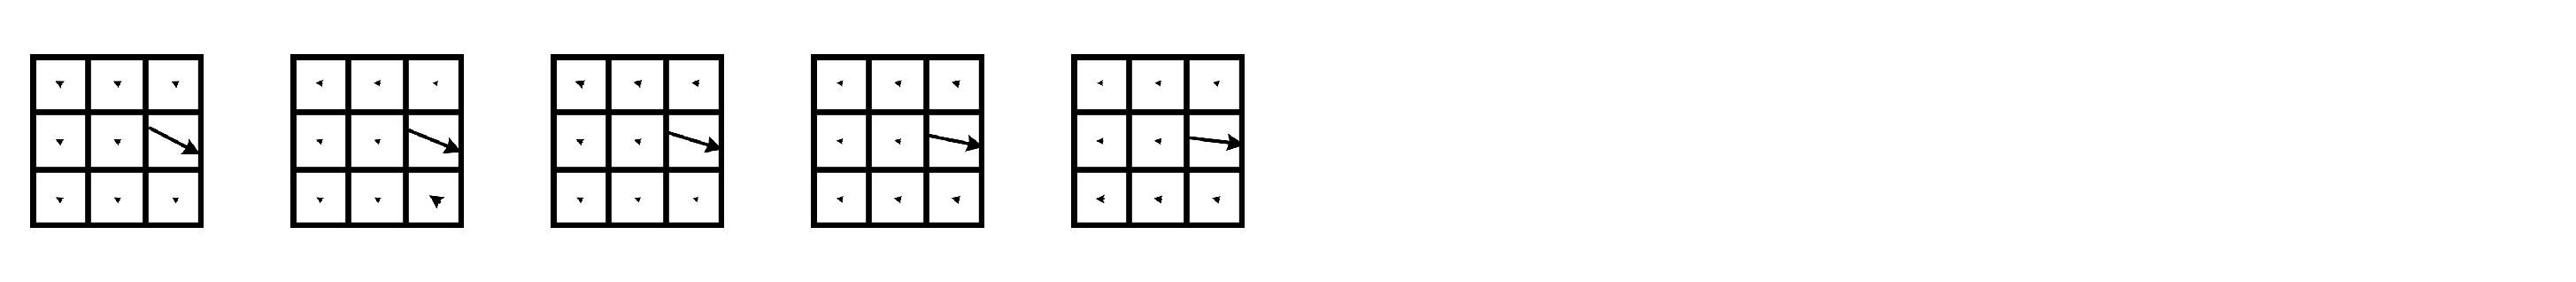

Sample patches from global cluster 44 (8 total)


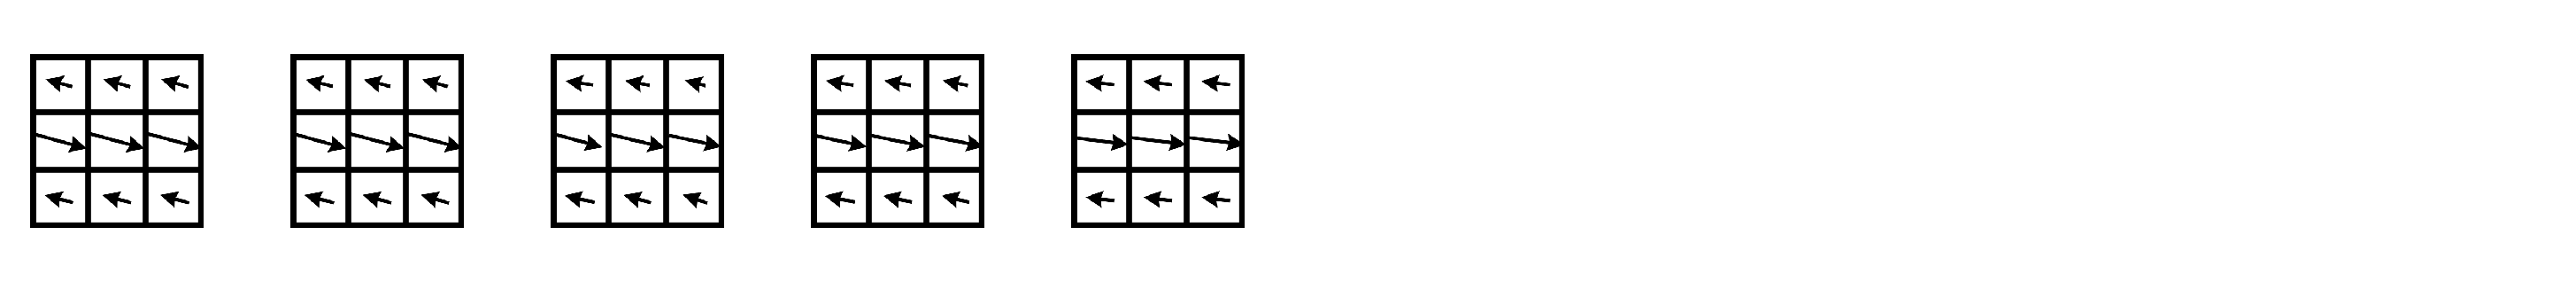

In [12]:
#View samples in each 'non-circular' global cluster 
save_path = None
for j in others:
    inds = comp_inds[j].astype(bool)        
    print(f'Sample patches from global cluster {j} ({int(np.sum(inds))} total)')
    fig = cb.show_data_vis(data[inds], patch_vis, angles = predom_dirs[inds], max_samples = 5, save_path = save_path)
    plt.show()


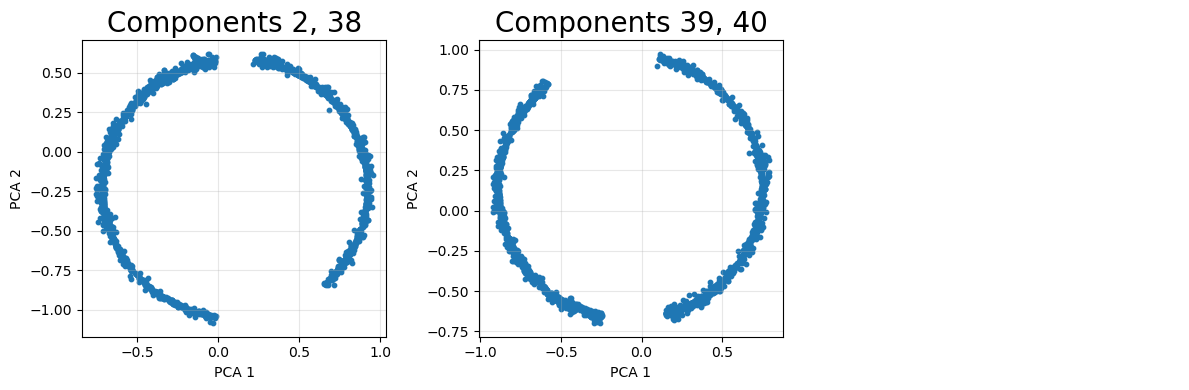

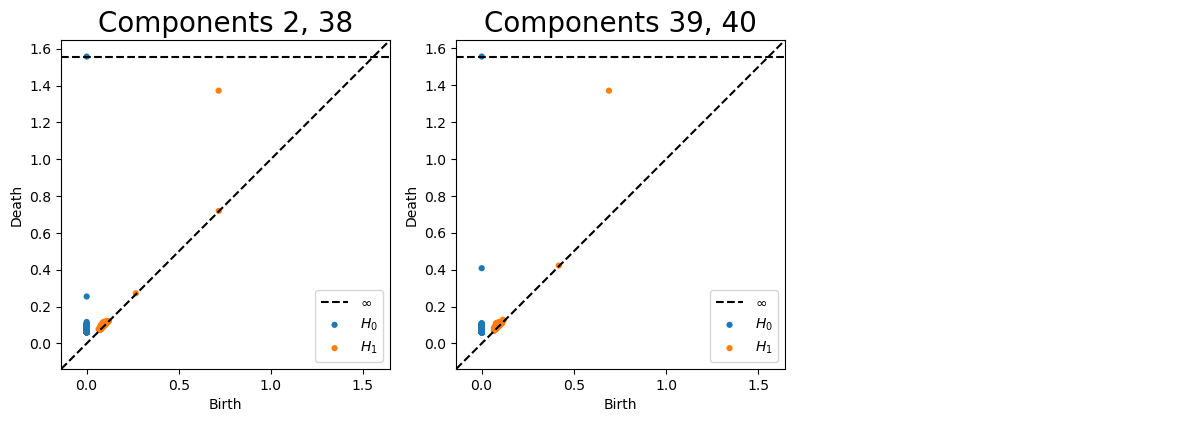

In [13]:
#Fuse cluster pairs
bunches = [[2, 38], [39, 40]]
bunch_inds = np.zeros((len(bunches), len(data)))
for j, bunch in enumerate(bunches):
    for component in bunch:
        bunch_inds[j] += comp_inds[component]

#Show PCA of the composite circles
fiber_ids, dense_idx_list, proj_list = cb.get_local_pca(
    data,
    bunch_inds,
    p_values=None,
    to_view=None,
    n_components=2,
    random_state=None)

titles = [f'Components 2, 38', 'Components 39, 40']
file_name = 'composite_circles_PCA.pdf'
save_path = folder_path + file_name
save_path = None

fig, axes = cb.plot_local_pca(
    fiber_ids,
    proj_list,
    n_cols=3,
    titles=titles,
    font_size=20,
    save_path=save_path)

#Show persistence of the composite circles
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    bunch_inds,
    p_values=None,
    to_view=None,
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles=titles,
    font_size=20,
    save_path=None,
)

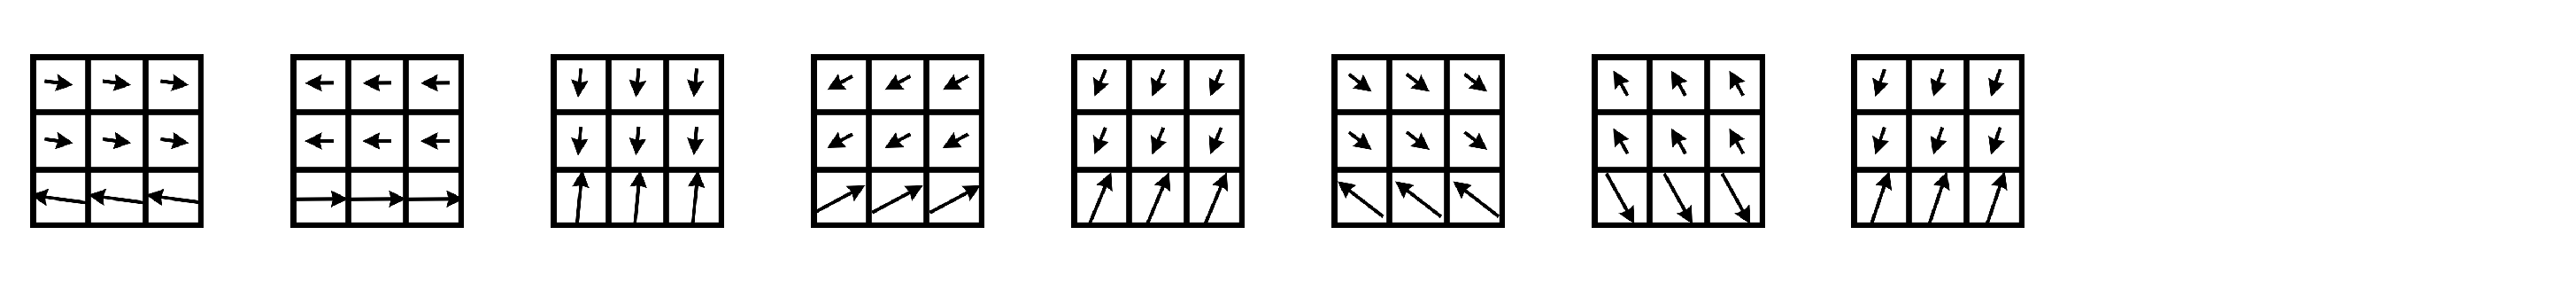

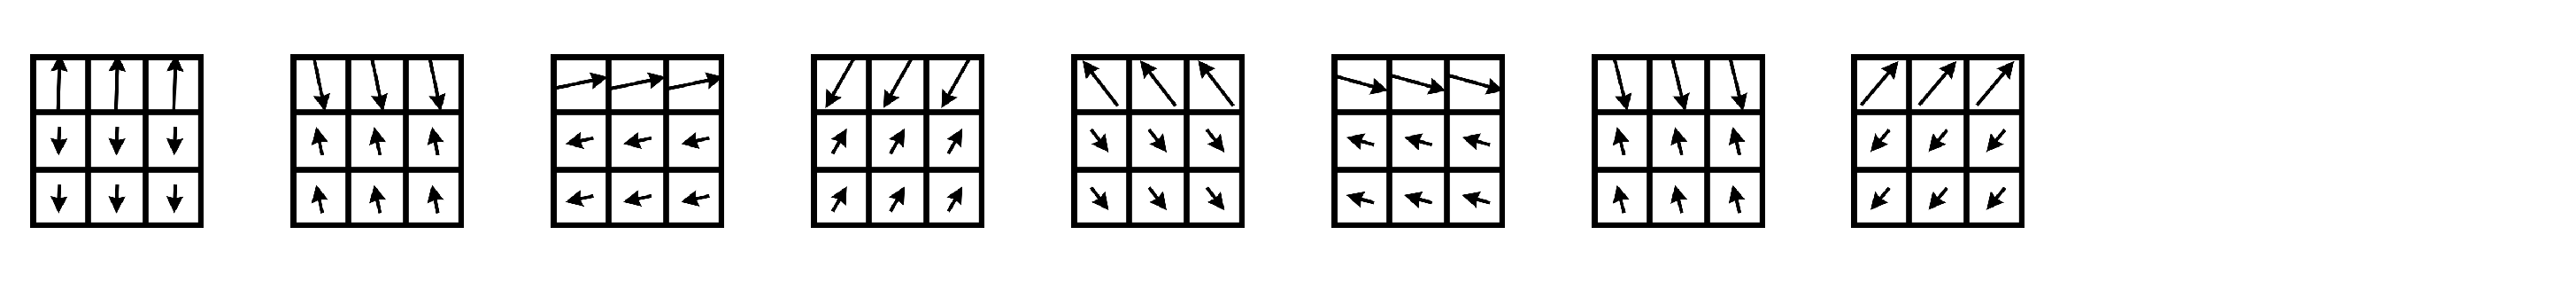

In [14]:
#Get a small number of synthetic binary step edge patches from the hypothesized circles
import synthetic as sy

samples_per_filament = 250
patch_types_list = sy.get_patch_types_list()

#Show some samples
spots = 18
synth_patches_A, synth_angles_A = sy.make_step_edges(samples_per_filament, patch_types_list[spots])
fig, axes = cb.show_data_vis(synth_patches_A, patch_vis, max_samples = 8)
plt.show()

spots = 16
synth_patches_B, synth_angles_B = sy.make_step_edges(samples_per_filament, patch_types_list[spots])
fig, axes = cb.show_data_vis(synth_patches_B, patch_vis, max_samples = 8)
plt.show()

#Create combined datasets for computing circular coordinates
boosted_circ_A = np.concatenate((data[bunch_inds[0].astype(bool)], synth_patches_A))
boosted_circ_B = np.concatenate((data[bunch_inds[1].astype(bool)], synth_patches_B))
boosted_circs = [boosted_circ_A, boosted_circ_B]


In [15]:
# Run circular coordinates on each composite component
n_landmarks = 100
prime = 17

file_name = 'Sample_ccs_missing_circs.pdf'
save_path = folder_path + file_name

composite_datasets = []
composite_angs_list = []
titles = []

for j, circ in enumerate(boosted_circs):
    composite_datasets.append(data[bunch_inds[j].astype(bool)])
    cc = CircularCoords(circ, n_landmarks, prime=prime)
    composite_angs_list.append(cc.get_coordinates()[:-samples_per_filament])
    titles.append(f"Components {', '.join(map(str, bunches[j]))}")    

file_name = 'Sample_ccs_50_60.pdf'
save_path = folder_path + file_name

fig, axes = cb.circle_vis_grid(
    datasets,
    composite_angs_list,
    patch_vis,
    titles=titles,
    per_circle=8,
    circle_radius=1.0,
    extent_factor=1.2,
    circle_zoom=0.13,
    circle_linewidth=1.0,
    circle_color="black",
    n_cols=4,
    title_fontsize=16,
    figsize_per_panel=5,
    fig_dpi=150,
    save_path=None,
)
plt.show()

NameError: name 'datasets' is not defined

# Additional Visualizations And Summaries

In [ ]:
#Get a sample patch from each noise cluster
noise_clusters = [comp for comp in others if comp not in [2, 38, 39, 40]]

datasets = [data[comp_inds[clust].astype(bool)] for clust in noise_clusters]
samples = np.vstack([data[0] for data in datasets])
save_path = None
fig = show_data_vis(samples, patch_vis, save_path = save_path, n_cols = 7)
plt.show()


In [ ]:
#Create an array whose rows track the final global clusters

#Combine the 'noise' clusters into a single cluster
new_bunches = bunches.copy()
new_bunches.append(noise_clusters)

#Combine the bunches into single clusters
C_final = np.copy(comp_inds)
to_delete = []
for bunch in new_bunches:
    m = min(bunch)
    for component in bunch:
        if component != m:
            C_final[m] += C_final[component]            
            to_delete.append(component)
C_final = np.delete(C_final, to_delete, axis=0)

#Rearrange everything to make it logical
C_final[[0, 2, 4, 27, 28, 29]] = C_final[[4, 27, 0, 2, 29, 28]]

#Note that the last 'component' is just the outlier data combined
print(C_final.shape)

#Create a 1D array with the final cluster labels
cluster_labels = np.full(C_final.shape[1], -1, dtype=int)

cols_with_one = np.any(C_final == 1, axis=0)
cluster_labels[cols_with_one] = np.argmax(C_final[:, cols_with_one], axis=0)


In [ ]:
#Show an interactive fiberwise visualization of the dataset colored by global cluster assignment
#bundle.show_bundle(colors = cluster_labels)

In [ ]:
#Show PCA of the dataset colored by global component

show_pca(data, U = C_final.astype(bool), max_points = 50000)
#Show the data in just the circular global clusters
#indices = np.sum(C_final[1:-1], axis = 0).astype(bool)
#show_pca(data[indices], U = C_final[1:-1, indices])

In [ ]:
# Show the coordinatized patches in all 28 recovered step-edge circles 
n_landmarks = 100
prime = 17

circle_datasets = []
all_angles = []
titles = []

for j in range(30):
    indices = C_final[j]
    if j not in [0,27, 28, 29]:   
        circle_datasets.append(data[indices])
        cc = CircularCoords(data[indices], n_landmarks, prime=prime)
        all_angles.append(cc.get_coordinates())
        titles.append(f'Component {j}')
    elif j in [27,28]:
        circle_datasets.append(composite_datasets[j-27])
        all_angles.append(composite_angs_list[j-27])
        titles.append(f"Components {', '.join(map(str, bunches[j-27]))}")    

#to_show = [7,20,23, 4, 5, 6]
file_name = 'Sample_ccs_50_60.pdf'
save_path = folder_path + file_name

fig, axes = circle_vis_grid(
    circle_datasets,
    all_angles,
    patch_vis,
    titles=titles,
    per_circle=8,
    circle_radius=1.0,
    extent_factor=1.2,
    circle_figsize=5,
    circle_dpi=150,
    circle_zoom=0.13,
    circle_linewidth=1.0,
    circle_color="black",
    n_cols=4,
    title_fontsize=16,
    figsize_per_panel=5,
    fig_dpi=150,
    save_path=None,
)
plt.show()

In [ ]:
#Show correlations between circular coordinate and predominant direction on each circular component
from circle_bundles.viz.angles import *

angle_arrays = []
to_compare = []
labels = []
for j, ang_arr in enumerate(all_angles):
    angle_arrays.append(ang_arr)
    indices = C_final[j+1]
    predoms = predom_dirs[indices]
    angle_arrays.append(predoms)
    labels.append(f'Circular Coordinate')
    labels.append(f'Predominant Axis')
    to_compare.append([2*j+1,2*j])


fig = compare_angle_pairs(
    angle_arrays,
    to_compare,
    labels = labels,
    align = False,
    s = 1.0,
    fontsize = 14,
    ncols = "auto",
    titles = None,
    titlesize = 14,
    show_metrics = False)
plt.show()


In [ ]:
#Show a representative from each circular component
samples = np.vstack([data[0] for data in circle_datasets])
save_path = None
fig = show_data_vis(samples, patch_vis, save_path = save_path, n_cols = 14)
plt.show()


In [ ]:
#Show samples from a pair of circles that look superimposed in the PCA
fig, axes = show_data_vis(data[C_final[1]], patch_vis, max_samples = 8)
plt.show()
fig, axes = show_data_vis(data[C_final[4]], patch_vis, max_samples = 8)
plt.show()

## Lifting The Step Edge Circles

In [ ]:
#Isolate the data in the step edge circles
circ_inds = (C_final[0]+C_final[-1] == 0)*(np.any(C_final != 0, axis=0))
circ_data = data[circ_inds]
C_circ = C_final[1:-1, circ_inds]

print(f'{np.sum(circ_inds)} patches from the step edge circles')


In [ ]:
#Get a small number of synthetic binary step edge patches to fill in the composite circles
samples_per_filament = 250
patch_types_list = get_patch_types_list()
spots = [18, 16]

for j in range(2):
    #Generate patches for this circle
    synth_patches = make_step_edges(samples_per_filament, patch_types_list[spots[j]])[0]

    #Show some samples
    fig, axes = show_data_vis(synth_patches, patch_vis, max_samples = 8)
    plt.show()
    
    #Add the synthetic data to the circle dataset
    circ_data = np.concatenate((circ_data, synth_patches))

    new_cols = np.zeros((len(C_circ), samples_per_filament), dtype=bool)
    new_cols[26+j, :] = True
    C_circ = np.hstack([C_circ, new_cols])

print(f'Augmented dataset contains {len(circ_data)} patches')

In [ ]:
#Save the data
folder_path = '/Users/bradturow/Desktop/Circle Bundle Code'
file_name = 'K_50_60_Circles.pkl'
save_path = folder_path + file_name
with open(save_path, 'wb') as f:
    pickle.dump([circ_data, C_circ], f)

        

In [ ]:
#Compute lifted predominant angles in S1
lifted_base_points = get_lifted_predom_dirs(circ_data, eps=1e-12)

n_landmarks = 16
lmk_angs = np.linspace(0, 2*np.pi,n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.5
radius = overlap* np.pi/n_landmarks

lifted_cover = MetricBallCover(lifted_base_points, landmarks, radius, metric = S1_dist2)
lifted_cover_data = lifted_cover.build()
lifted_summ = lifted_cover.summarize(plot = True)

In [ ]:
#Try running circular coordinates on a single open set
j= 6
n_local_landmarks = 200
prime = 43
fiber_data = circ_data[lifted_cover.U[j]]
patch_angles, n_warnings, n_lmks = compute_circular_coords_dreimac(fiber_data, 
                                                                   n_landmarks_init = n_local_landmarks, 
                                                                   CircularCoords_cls = CircularCoords)

print(n_warnings, n_lmks)
show_pca(fiber_data, colors = patch_angles)




In [ ]:
#Compute local trivializations and characteristic classes
lifted_bundle = build_bundle(
    circ_data,
    lifted_cover,
    CircularCoords_cls=CircularCoords,  
    landmarks_per_patch = 500,
    show=True)


In [ ]:
fig = lifted_bundle.compare_trivs()
plt.show()

In [ ]:
triv_result = lifted_bundle.get_global_trivialization()
fiber_angles = triv_result.F
print('Global coordinates computed.')

In [ ]:
#Show a sample of coordinatized data

base_angles = np.arctan2(lifted_cover.base_points[:,1], lifted_cover.base_points[:,0]) % (2*np.pi)
coords = np.array([base_angles, fiber_angles]).T
file_name = 'Recovered_Lifted_Step_Edge_Torus.pdf'
save_path = folder_path + file_name
save_path = None
fig = lattice_vis(circ_data, coords, patch_vis, 
                             per_row=7,
                              per_col = 9,
                             figsize=16, save_path = save_path)
plt.show()


In [ ]:
#Show an interactive visualization of the bundle structure
fig = lifted_bundle.show_bundle(get_dist_mat = get_dist_mat, colors = fiber_angles)
plt.show()

## Optical Flow Torus 

In [ ]:
#Create a restricted bundle with just the largest connected component
oft_data = data[C_final[0]]
oft_base_points = cover.base_points[C_final[0]]
oft_dirs = predom_dirs[C_final[0]]

n_landmarks = 16
lmk_angs = np.linspace(0, 2*np.pi,n_landmarks, endpoint= False)
landmarks = np.array([np.cos(lmk_angs), np.sin(lmk_angs)]).T
overlap = 1.5
radius = overlap* np.pi/n_landmarks

oft_cover = MetricBallCover(oft_base_points, landmarks, radius, metric = S1_dist2)
oft_cover_data = cover.build()
oft_summ = oft_cover.summarize(plot = True)

In [ ]:
#View a sample of the dataset arranged by predominant flow direction
n_samples = 8

label_func = [fr"$\theta = {np.round(pred/np.pi, 2)}$" + r"$\pi$" for pred in predom_dirs]
file_name = 'opt flow sample.pdf'
save_path = folder_path + file_name
save_path = None
fig = show_data_vis(oft_data, patch_vis, label_func = label_func, angles = oft_dirs, sampling_method = 'angle', max_samples = n_samples, save_path = save_path)
plt.show()


In [ ]:
#Run Ripser on the dataset
from ripser import ripser
from persim import plot_diagrams

diagrams = ripser(oft_data, maxdim = 2, n_perm = 500)['dgms']
plot_diagrams(diagrams, show=True)    

In [ ]:
#Try running circular coordinates on a single open set
j= 0
n_local_landmarks = 200
prime = 43
fiber_data = oft_data[oft_cover.U[j]]
patch_angles, n_warnings, n_lmks = compute_circular_coords_dreimac(fiber_data, 
                                                                   n_landmarks_init = n_local_landmarks, 
                                                                   CircularCoords_cls = CircularCoords)

print(n_warnings, n_lmks)
show_pca(fiber_data, colors = patch_angles)




In [ ]:
#Compute local trivializations and characteristic classes
oft_bundle = build_bundle(
    oft_data,
    oft_cover,
    CircularCoords_cls=CircularCoords,  
    show=True)


In [ ]:
#View the correlations between local circular coordinates on overlaps
file_name = 'real_oft_correlations2.pdf'
save_path = folder_path + file_name
save_path = None
fig = oft_bundle.compare_trivs(ncols = 4, save_path = save_path)
plt.show()

In [ ]:
#Get a global coordinatization compatible with the maximal subcomplex of the nerve on which 
#the characteristic class representatives are coboundaries 

oft_result = oft_bundle.get_global_trivialization()
fiber_angles = oft_result.F
print('Global coordinates computed.')

In [ ]:
#Show a visualization of the nerve labeled with SW1

#Compute a potential for the restricted orientation class
subcomplex = oft_bundle.get_max_trivial_subcomplex()
edges = subcomplex.kept_edges
Omega = oft_bundle.classes.cocycle_used.restrict(edges)
phi_vec = Omega.orient_if_possible(edges)[2]
phi = {lmk: phi_vec[lmk] for lmk in range(n_landmarks)}
omega = oft_bundle.classes.omega_O1_used

save_path = folder_path + 'real_oft_nerve.pdf'
save_path = None


fig = oft_bundle.show_circle_nerve(omega = omega, phi = phi, save_path = save_path)
plt.show()

In [ ]:
#Show a sample of coordinatized data

base_angles = np.arctan2(oft_cover.base_points[:,1], oft_cover.base_points[:,0]) % (2*np.pi)
coords = np.array([base_angles, fiber_angles]).T
file_name = 'Recovered_OFT_Diagram_K_50_60_All.pdf'
save_path = folder_path + file_name
save_path = None
fig = lattice_vis(oft_data, coords, patch_vis, 
                             per_row=5,
                              per_col = 9,
                             figsize=16, save_path = save_path)
plt.show()


In [ ]:
#Restrict to high-directionality data
oft_ratios = get_predominant_dirs(oft_data)[1]

#Set up a bundle with just the high-directionality data
thresh = 0.8
high_inds = oft_ratios > thresh
print(f'{np.sum(high_inds)} high-directionality patches')

high_cover = MetricBallCover(oft_base_points[high_inds], landmarks, radius, metric = S1_dist2)
high_cover_data = high_cover.build()

#Show a summary of the construction
high_summ = high_cover.summarize(plot = True)

In [ ]:
#Construct local circular coordinates and model transitions as O(2) matrices
high_bundle = build_bundle(
    oft_data[high_inds],
    high_cover,
    CircularCoords_cls=CircularCoords,
    show=True,
)


In [ ]:
save_path = None
fig = high_bundle.compare_trivs(ncols = 4, save_path = save_path)
plt.show()

In [ ]:
high_triv_result = high_bundle.get_global_trivialization()
high_fiber_angles = high_triv_result.F
print('global coordinates computed.')

In [ ]:
#Show a recovered patch diagram
per_row = 5
per_col = 9
coords = np.array([oft_dirs[high_inds], high_fiber_angles]).T
file_name = 'Real_OFT_Diagram_High.pdf'
save_path = folder_path + file_name
save_path = None

fig = lattice_vis(
    high_bundle.data,
    coords,
    patch_vis,
    per_row=per_row,
    per_col = per_col,
    figsize=12,
    thumb_px=350,   
    dpi=350, 
    save_path = save_path,
    padding = 0
)

plt.show()
